# CORAL RESNET34

In [1]:
!nvidia-smi

Mon Aug 30 17:37:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# import argparse

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
TRAIN_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/UTKFace_1-101_class-97-label-0-96-final.csv'
IMAGE_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/UTKFace-images'

RANDOM_SEED = 42
MODEL_NAME = "Full-UTK-CORAL_ResNet34-Pretrained-Finetuned_100%-EPOCHS-25-withourLRS"
PATH = "/content/drive/MyDrive/CSE465/Models_and_Logs/" + MODEL_NAME

GRAYSCALE = False
NUM_CLASSES = 97
BATCH_SIZE = 128
EPOCHS = 25
learning_rate = 0.0005
NUM_WORKERS = 0
IMP_WEIGHT = 1
learning_rate_scheduler = False

In [5]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'training.log')

In [7]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Model Name: {MODEL_NAME}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'Learning Rate: {learning_rate}')
header.append(f'Epochs: {EPOCHS}')
if learning_rate_scheduler:
  header.append(f'Learning Rate Schedule: {learning_rate_scheduler}')

In [8]:
for entry in header:
  print(entry)




Last Run: 2021-08-30 23:37:24.965272+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Model Name: Full-UTK-CORAL_ResNet34-Pretrained-Finetuned_100%-EPOCHS-25-withourLRS
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/Full-UTK-CORAL_ResNet34-Pretrained-Finetuned_100%-EPOCHS-25-withourLRS
-------------------HyperParameters---------------
No. of Classes: 97
Batch size: 128
Grayscale: False
Learning Rate: 0.0005
Epochs: 25


In [9]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

In [10]:
df = pd.read_csv(TRAIN_CSV_PATH)
labels = df['label'].values
del df
labels = torch.tensor(labels, dtype=torch.float)
labels.size()

torch.Size([23207])

In [11]:
uniq = torch.unique(labels) #0-96
num_examples = labels.size(0) #23207

m = torch.zeros(uniq.shape[0]) #tensor of 97 zeros
# j=0
# lol = torch.arange(torch.min(uniq), torch.max(uniq))
# print(lol) #0-95
# x = torch.tensor(labels[labels > j]).size(0)
# print(x) #no. of examples that have ages greater than j
# y = num_examples - labels[labels > j].size(0)
# print(y) #no. of examples have ages less than or equal to j
# a = torch.tensor([x, y]) #a tensor with two elements
# print(a)
# max = torch.max(a)
# print(max) #so samples greater than age 1 are more
# root = torch.sqrt(max.float())
# print(root) # square root of max of a

for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq))):
    m_k = torch.max(torch.tensor([labels[labels > t].size(0), 
                                  num_examples - labels[labels > t].size(0)]))
    m[i] = torch.sqrt(m_k.float())

imp = m/torch.max(m)
print(m)
print(imp)

tensor([148.6069, 147.6313, 146.7038, 146.0342, 145.5850, 145.1069, 144.1978,
        143.6210, 143.0769, 142.8496, 142.3938, 142.1091, 141.5556, 140.9291,
        140.0500, 139.4848, 138.5424, 138.1883, 137.1568, 135.8897, 134.4284,
        132.8345, 129.5608, 126.6965, 117.7073, 115.0652, 111.0045, 108.4066,
        110.3585, 111.9330, 114.8608, 115.4816, 117.2391, 120.9339, 122.9146,
        124.1008, 125.4034, 126.4595, 128.5224, 129.0349, 130.0615, 130.6637,
        131.0458, 132.7140, 133.2892, 133.9254, 134.4953, 135.0444, 136.4478,
        136.9525, 137.7970, 138.6687, 139.9357, 140.8900, 141.7251, 142.0669,
        143.0175, 143.3039, 144.3226, 144.8793, 145.3100, 145.6640, 145.8355,
        146.7208, 146.9830, 147.3024, 147.6415, 147.8310, 148.3273, 148.4385,
        148.7683, 148.9799, 149.0872, 149.5827, 149.7765, 149.8699, 150.1000,
        150.1766, 150.6187, 150.6917, 150.8244, 150.8841, 150.9636, 151.4761,
        151.5916, 151.6245, 151.7366, 151.8453, 152.1151, 152.12

In [12]:
def task_importance_weights(label_array):
    uniq = torch.unique(label_array)
    num_examples = label_array.size(0)

    m = torch.zeros(uniq.shape[0])

    for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq))):
        m_k = torch.max(torch.tensor([label_array[label_array > t].size(0), 
                                      num_examples - label_array[label_array > t].size(0)]))
        m[i] = torch.sqrt(m_k.float())

    imp = m/torch.max(m)
    return imp

In [13]:
# Data-specific scheme
if not IMP_WEIGHT:
    imp = torch.ones(NUM_CLASSES-1, dtype=torch.float)
elif IMP_WEIGHT == 1:
    imp = task_importance_weights(labels)
    imp = imp[0:NUM_CLASSES-1]
else:
    raise ValueError('Incorrect importance weight parameter.')
imp = imp.to(DEVICE)

 **Dataset**

In [14]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""

    def __init__(self, csv_path, img_dir, transform=None, items=None):
        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')

        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        # img = img.convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        levels = [1]*label + [0]*(NUM_CLASSES - 1 - label) #converting labels to levels..so if age is 22, 22 ones and (96-22) zeros
        levels = torch.tensor(levels, dtype=torch.float32)

        return img, label, levels
        
    def __len__(self):
        return self.y.shape[0]

In [15]:
custom_transform_train = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.RandomCrop((224, 224)),
                                       transforms.ToTensor(),
                                       ])

train_dataset = UTKFaceDataset(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH,
                               transform=custom_transform_train,
                               items = None
                               )

# image, label, level = train_dataset.__getitem__(0)
# label, level, level.shape

**Dataset Entity Distribution Analysis**

In [16]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

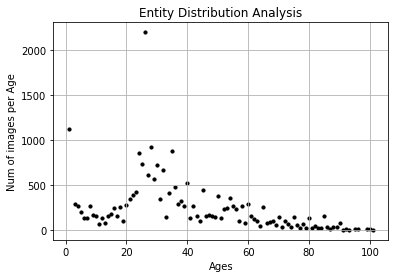

label		Age		Count
0 		 1 		 1123
1 		 3 		 289
2 		 4 		 273
3 		 5 		 196
4 		 6 		 131
5 		 7 		 139
6 		 8 		 263
7 		 9 		 166
8 		 10 		 156
9 		 11 		 65
10 		 12 		 130
11 		 13 		 81
12 		 14 		 157
13 		 15 		 177
14 		 16 		 247
15 		 17 		 158
16 		 18 		 262
17 		 19 		 98
18 		 20 		 284
19 		 21 		 346
20 		 22 		 395
21 		 23 		 426
22 		 24 		 859
23 		 25 		 734
24 		 26 		 2197
25 		 27 		 615
26 		 28 		 918
27 		 29 		 570
28 		 30 		 724
29 		 31 		 350
30 		 32 		 664
31 		 33 		 143
32 		 34 		 409
33 		 35 		 880
34 		 36 		 483
35 		 37 		 293
36 		 38 		 325
37 		 39 		 266
38 		 40 		 526
39 		 41 		 132
40 		 42 		 266
41 		 43 		 157
42 		 44 		 100
43 		 45 		 440
44 		 46 		 153
45 		 47 		 170
46 		 48 		 153
47 		 49 		 148
48 		 50 		 381
49 		 51 		 138
50 		 52 		 232
51 		 53 		 241
52 		 54 		 353
53 		 55 		 268
54 		 56 		 236
55 		 57 		 97
56 		 58 		 271
57 		 59 		 82
58 		 60 		 293
59 		 61 		 161
60 		 62 		 125
61 		 63 		 103
62 		 64 		

In [17]:
dataset_analysis(train_dataset)

**Dataset Loader**

In [18]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

In [19]:
len(train_loader)

182

In [20]:
# t = torch.zeros(NUM_CLASSES-1).float()
# print(type(t))
# print(t.shape)
# print(t)

In [21]:
# logits = 1000000
# logits = logits + t
# print(logits)

In [22]:
# torch.sigmoid(logits)

In [23]:
# t1 = torch.randn(3,3)
# print(t1)
# t2 = torch.sigmoid(t1)
# print(t2)
# t3 = t2 > 0.5
# print(t3)

# torch.sum(t3, 1)

In [24]:
# _, idx = torch.max(t2, dim=1)
# idx

**Model**

**Initialise Model & Optimizer**

In [25]:
# import torchvision.models as models
# from torchvision.models.resnet import ResNet, BasicBlock

# pretrained_model = models.resnet34(pretrained=True)
# class MyResNet34(nn.Module):
#     def __init__(self, pretrained_model):
#         super(MyResNet34, self).__init__()
#         self.pretrained = pretrained_model
#         self.pretrained.fc = nn.Linear(model.fc.in_features, 1, bias = False)
#         self.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES-1).float())
        
#     def forward(self, x):
#         # x = self.conv1(x)
#         # x = self.bn1(x)
#         # x = self.relu(x)
#         # x = self.maxpool(x)

#         # x = self.layer1(x)
#         # x = self.layer2(x)
#         # x = self.layer3(x)
#         # x = self.layer4(x)

#         # x = self.avgpool(x)
#         # x = torch.flatten(x, 1)
#         # logits = self.fc(x)
#         logits = self.pretrained(x)
#         logits = logits + self.linear_1_bias
#         probas = torch.sigmoid(logits) 
#         return logits, probas

In [26]:
# a = MyResNet34(pretrained_model)
# for name,param in a.named_parameters():
#   print(name)

In [27]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1, bias = False)
# model.fc.in_features is 512
model.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES-1).float()) 


params_to_update = model.parameters()
print("Params to learn:")
for name,param in model.named_parameters(): print("\t",name)

model.to(DEVICE)
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
if learning_rate_scheduler:
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Params to learn:
	 linear_1_bias
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer2.2.conv1.weight
	 layer2.2.bn1.weight
	 layer2.2.bn1.bias
	 layer2.2.conv2.weight
	 layer2.2.bn2.weight
	 layer2.2.bn2.bias
	 layer2.3.conv1.weight
	 layer2.3.bn1.weight

In [28]:
# model.linear_1_bias.shape

In [29]:
# model.linear_1_bias

In [30]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
# x = torch.rand([1,3,224,224])
# logits = model(x)
# logits = logits + model.linear_1_bias[0:5]
# print(logits)
# print('---------------------------------------')
# t = F.logsigmoid(logits)
# print(t)
# print('---------------------------------------')
# y = torch.tensor([1,1,0,0,0])
# t = t*y
# print(t)
# print('---------------------------------------')
# f = F.logsigmoid(logits) - logits
# print(f)
# print('---------------------------------------')
# y_inv = 1-y
# f = f*y_inv
# print(f)
# print('---------------------------------------')
# total = -torch.sum(t+f)
# print(total)
# print('---------------------------------------')
# imp_weight = 0.997
# total = total*imp

In [32]:
# m = nn.LogSigmoid()
# lol = torch.tensor([-10000000000000.0])
# m(lol)

In [33]:
#logsigmoid range -infinity to 0
def cost_fn(logits, levels, imp):
    val = (-torch.sum((F.logsigmoid(logits)*levels
                      + (F.logsigmoid(logits) - logits)*(1-levels))*imp,
           dim=1))
    return torch.mean(val)

`torch.max()` `returns` highest elements along the dimension and indexes of highest values, here we are only interested to the indexes of highest elements

In [34]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [35]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

**Training**

PyTorch Normally add the previously calculated gradient with the current calculated gradient and then updates the weight. But here we don't want it. That's why we made the previously calculted gradient zero while calculating a new one with `optimizer.zero_grad()`

In [36]:
# x = torch.rand([1,3,224,224])
# logits = model(x)
# logits = logits + model.linear_1_bias[0:5]
# print(logits)
# print('---------------------------------------')
# probas = torch.sigmoid(logits)

In [37]:
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
  train_total_num_correct_preds = train_num_examples = 0

  model.train()
  train_mae=0.0
  for batch_idx, (features, targets, levels) in enumerate(tqdm(train_loader)):

    features = features.to(DEVICE)
    targets = targets.to(DEVICE)
    levels = levels.to(DEVICE)

    # FORWARD AND BACK PROP
    logits = model(features)
    logits = logits + model.linear_1_bias
    cost = cost_fn(logits, levels, imp)
    probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5
    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)

    # _, predicted_labels = torch.max(probas, dim=1)
    optimizer.zero_grad()

    cost.backward()

    # UPDATE MODEL PARAMETERS
    optimizer.step()
    # UPDATE LEARNING RATE
    if learning_rate_scheduler:
      scheduler.step()

    train_total_num_correct_preds += num_correct_preds
    train_num_examples += targets.size(0) 
    train_mae += torch.sum(torch.abs(predicted_labels - targets))
      
  train_mae = train_mae/train_num_examples
  # LOGGING
  print(f'Correct Train Preds: {train_total_num_correct_preds}')
  training_acc = compute_acc(train_total_num_correct_preds, train_num_examples)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  str1 = f'Epoch: {epoch+1}/{EPOCHS} \n'
  str2 = f'--------------------------------------------------------------------\n'
  str3 = f'Training MAE: {format(train_mae, ".3f")}\n'
  str4 = f'Training_Cost: {format(cost, ".3f")}\n'
  str5 = f'Training_Acc: {training_acc}%\n'
  str6 = f'Time elapsed: {time_elapsed}mins\n'

  str = str1+str2+str3+str4+str5+str6
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')
  
  mode_name = f'Epoch_{epoch+1}_model.pt'
  torch.save(model.state_dict(), os.path.join(PATH, mode_name)) # saving the model
  with open(LOGFILE, 'a') as f: f.write(f'---Model Saved---\n')
  print(f'---Model Saved---\n')
    
with open(LOGFILE, 'a') as f: f.write('\n\n############-------Training Completed-------############\n\n')
print("TRAINING COMPLETED")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Correct Train Preds: 1124
Epoch: 1/25 
--------------------------------------------------------------------
Training MAE: 27.647
Training_Cost: 50.040
Training_Acc: 4.843%
Time elapsed: 2.513mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1150
Epoch: 2/25 
--------------------------------------------------------------------
Training MAE: 25.393
Training_Cost: 46.531
Training_Acc: 4.955%
Time elapsed: 5.027mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1175
Epoch: 3/25 
--------------------------------------------------------------------
Training MAE: 23.989
Training_Cost: 39.828
Training_Acc: 5.063%
Time elapsed: 7.561mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1192
Epoch: 4/25 
--------------------------------------------------------------------
Training MAE: 22.570
Training_Cost: 38.468
Training_Acc: 5.136%
Time elapsed: 10.088mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1201
Epoch: 5/25 
--------------------------------------------------------------------
Training MAE: 21.253
Training_Cost: 42.285
Training_Acc: 5.175%
Time elapsed: 12.644mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1239
Epoch: 6/25 
--------------------------------------------------------------------
Training MAE: 20.054
Training_Cost: 39.219
Training_Acc: 5.339%
Time elapsed: 15.139mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1291
Epoch: 7/25 
--------------------------------------------------------------------
Training MAE: 18.822
Training_Cost: 35.669
Training_Acc: 5.563%
Time elapsed: 17.663mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1332
Epoch: 8/25 
--------------------------------------------------------------------
Training MAE: 17.421
Training_Cost: 33.625
Training_Acc: 5.740%
Time elapsed: 20.191mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1415
Epoch: 9/25 
--------------------------------------------------------------------
Training MAE: 16.103
Training_Cost: 31.569
Training_Acc: 6.097%
Time elapsed: 22.711mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1561
Epoch: 10/25 
--------------------------------------------------------------------
Training MAE: 14.430
Training_Cost: 30.608
Training_Acc: 6.726%
Time elapsed: 25.242mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1717
Epoch: 11/25 
--------------------------------------------------------------------
Training MAE: 12.735
Training_Cost: 28.652
Training_Acc: 7.399%
Time elapsed: 27.767mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2010
Epoch: 12/25 
--------------------------------------------------------------------
Training MAE: 10.975
Training_Cost: 30.601
Training_Acc: 8.661%
Time elapsed: 30.277mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2201
Epoch: 13/25 
--------------------------------------------------------------------
Training MAE: 9.559
Training_Cost: 25.994
Training_Acc: 9.484%
Time elapsed: 32.815mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2480
Epoch: 14/25 
--------------------------------------------------------------------
Training MAE: 8.330
Training_Cost: 26.970
Training_Acc: 10.686%
Time elapsed: 35.347mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2544
Epoch: 15/25 
--------------------------------------------------------------------
Training MAE: 7.389
Training_Cost: 26.903
Training_Acc: 10.962%
Time elapsed: 37.884mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2610
Epoch: 16/25 
--------------------------------------------------------------------
Training MAE: 6.883
Training_Cost: 24.893
Training_Acc: 11.247%
Time elapsed: 40.397mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2603
Epoch: 17/25 
--------------------------------------------------------------------
Training MAE: 6.582
Training_Cost: 26.400
Training_Acc: 11.216%
Time elapsed: 42.940mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2627
Epoch: 18/25 
--------------------------------------------------------------------
Training MAE: 6.302
Training_Cost: 25.799
Training_Acc: 11.320%
Time elapsed: 45.474mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2587
Epoch: 19/25 
--------------------------------------------------------------------
Training MAE: 6.093
Training_Cost: 23.780
Training_Acc: 11.147%
Time elapsed: 48.000mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2649
Epoch: 20/25 
--------------------------------------------------------------------
Training MAE: 5.959
Training_Cost: 22.153
Training_Acc: 11.415%
Time elapsed: 50.536mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2561
Epoch: 21/25 
--------------------------------------------------------------------
Training MAE: 5.996
Training_Cost: 21.370
Training_Acc: 11.035%
Time elapsed: 53.086mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2529
Epoch: 22/25 
--------------------------------------------------------------------
Training MAE: 5.754
Training_Cost: 21.853
Training_Acc: 10.898%
Time elapsed: 55.610mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2627
Epoch: 23/25 
--------------------------------------------------------------------
Training MAE: 5.633
Training_Cost: 20.846
Training_Acc: 11.320%
Time elapsed: 58.141mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2558
Epoch: 24/25 
--------------------------------------------------------------------
Training MAE: 5.548
Training_Cost: 19.313
Training_Acc: 11.023%
Time elapsed: 60.669mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2654
Epoch: 25/25 
--------------------------------------------------------------------
Training MAE: 5.409
Training_Cost: 19.623
Training_Acc: 11.436%
Time elapsed: 63.200mins

---Model Saved---

TRAINING COMPLETED


**Evaluataion**

In [38]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets, levels) in enumerate(data_loader):
          
    targets, features = targets.to(device), features.to(device)
    logits = model(features)
    logits = logits + model.linear_1_bias
    probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5

    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

In [39]:
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

  train_mae, train_mse, train_acc = compute_mae_and_mse(model, train_loader, device=DEVICE)
  str1 = f'Training MAE: {train_mae}\n'
  str2 = f'Training RMSE: {train_mse}\n'
  str3 = f'Training Acc: {train_acc}%\n'
  str = str1+str2+str3

  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')

str = f'Total Elapsed Time: {format(((time.time() - start_time)/60), ".3f")} mins \n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

total_num_correct_preds: 2619
Training MAE: 5.136
Training RMSE: 7.026
Training Acc: 11.285%

Total Elapsed Time: 64.637 mins 



**Saving the Model**

PyTorch: What's the difference between state_dict and parameters()? [link](https://stackoverflow.com/questions/54746829/pytorch-whats-the-difference-between-state-dict-and-parameters)

In [40]:
# model = model.to(torch.device('cpu'))
# torch.save(model.state_dict(), os.path.join(PATH, 'model.pt'))

# CORAL RESNET18

In [41]:
!nvidia-smi

Mon Aug 30 18:42:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    45W / 250W |   6245MiB / 16280MiB |     57%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [42]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# import argparse

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
TRAIN_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/UTKFace_1-101_class-97-label-0-96-final.csv'
IMAGE_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/UTKFace-images'

RANDOM_SEED = 42
MODEL_NAME = "Full-UTK-CORAL_ResNet18-Pretrained-Finetuned_100%-EPOCHS-25-withourLRS"
PATH = "/content/drive/MyDrive/CSE465/Models_and_Logs/" + MODEL_NAME

GRAYSCALE = False
NUM_CLASSES = 97
BATCH_SIZE = 128
EPOCHS = 25
learning_rate = 0.0005
NUM_WORKERS = 0
IMP_WEIGHT = 1
learning_rate_scheduler = False

In [45]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [46]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'training.log')

In [47]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Model Name: {MODEL_NAME}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'Learning Rate: {learning_rate}')
header.append(f'Epochs: {EPOCHS}')
if learning_rate_scheduler:
  header.append(f'Learning Rate Schedule: {learning_rate_scheduler}')

In [48]:
for entry in header:
  print(entry)




Last Run: 2021-08-31 00:42:07.472395+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Model Name: Full-UTK-CORAL_ResNet18-Pretrained-Finetuned_100%-EPOCHS-25-withourLRS
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/Full-UTK-CORAL_ResNet18-Pretrained-Finetuned_100%-EPOCHS-25-withourLRS
-------------------HyperParameters---------------
No. of Classes: 97
Batch size: 128
Grayscale: False
Learning Rate: 0.0005
Epochs: 25


In [49]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

In [50]:
df = pd.read_csv(TRAIN_CSV_PATH)
labels = df['label'].values
del df
labels = torch.tensor(labels, dtype=torch.float)
labels.size()

torch.Size([23207])

In [51]:
uniq = torch.unique(labels) #0-96
num_examples = labels.size(0) #23207

m = torch.zeros(uniq.shape[0]) #tensor of 97 zeros
# j=0
# lol = torch.arange(torch.min(uniq), torch.max(uniq))
# print(lol) #0-95
# x = torch.tensor(labels[labels > j]).size(0)
# print(x) #no. of examples that have ages greater than j
# y = num_examples - labels[labels > j].size(0)
# print(y) #no. of examples have ages less than or equal to j
# a = torch.tensor([x, y]) #a tensor with two elements
# print(a)
# max = torch.max(a)
# print(max) #so samples greater than age 1 are more
# root = torch.sqrt(max.float())
# print(root) # square root of max of a

for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq))):
    m_k = torch.max(torch.tensor([labels[labels > t].size(0), 
                                  num_examples - labels[labels > t].size(0)]))
    m[i] = torch.sqrt(m_k.float())

imp = m/torch.max(m)
print(m)
print(imp)

tensor([148.6069, 147.6313, 146.7038, 146.0342, 145.5850, 145.1069, 144.1978,
        143.6210, 143.0769, 142.8496, 142.3938, 142.1091, 141.5556, 140.9291,
        140.0500, 139.4848, 138.5424, 138.1883, 137.1568, 135.8897, 134.4284,
        132.8345, 129.5608, 126.6965, 117.7073, 115.0652, 111.0045, 108.4066,
        110.3585, 111.9330, 114.8608, 115.4816, 117.2391, 120.9339, 122.9146,
        124.1008, 125.4034, 126.4595, 128.5224, 129.0349, 130.0615, 130.6637,
        131.0458, 132.7140, 133.2892, 133.9254, 134.4953, 135.0444, 136.4478,
        136.9525, 137.7970, 138.6687, 139.9357, 140.8900, 141.7251, 142.0669,
        143.0175, 143.3039, 144.3226, 144.8793, 145.3100, 145.6640, 145.8355,
        146.7208, 146.9830, 147.3024, 147.6415, 147.8310, 148.3273, 148.4385,
        148.7683, 148.9799, 149.0872, 149.5827, 149.7765, 149.8699, 150.1000,
        150.1766, 150.6187, 150.6917, 150.8244, 150.8841, 150.9636, 151.4761,
        151.5916, 151.6245, 151.7366, 151.8453, 152.1151, 152.12

In [52]:
def task_importance_weights(label_array):
    uniq = torch.unique(label_array)
    num_examples = label_array.size(0)

    m = torch.zeros(uniq.shape[0])

    for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq))):
        m_k = torch.max(torch.tensor([label_array[label_array > t].size(0), 
                                      num_examples - label_array[label_array > t].size(0)]))
        m[i] = torch.sqrt(m_k.float())

    imp = m/torch.max(m)
    return imp

In [53]:
# Data-specific scheme
if not IMP_WEIGHT:
    imp = torch.ones(NUM_CLASSES-1, dtype=torch.float)
elif IMP_WEIGHT == 1:
    imp = task_importance_weights(labels)
    imp = imp[0:NUM_CLASSES-1]
else:
    raise ValueError('Incorrect importance weight parameter.')
imp = imp.to(DEVICE)

 **Dataset**

In [54]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""

    def __init__(self, csv_path, img_dir, transform=None, items=None):
        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')

        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        # img = img.convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        levels = [1]*label + [0]*(NUM_CLASSES - 1 - label) #converting labels to levels..so if age is 22, 22 ones and (96-22) zeros
        levels = torch.tensor(levels, dtype=torch.float32)

        return img, label, levels
        
    def __len__(self):
        return self.y.shape[0]

In [55]:
custom_transform_train = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.RandomCrop((224, 224)),
                                       transforms.ToTensor(),
                                       ])

train_dataset = UTKFaceDataset(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH,
                               transform=custom_transform_train,
                               items = None
                               )

# image, label, level = train_dataset.__getitem__(0)
# label, level, level.shape

**Dataset Entity Distribution Analysis**

In [56]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

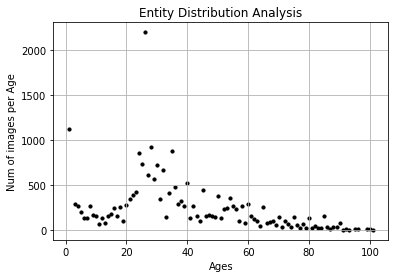

label		Age		Count
0 		 1 		 1123
1 		 3 		 289
2 		 4 		 273
3 		 5 		 196
4 		 6 		 131
5 		 7 		 139
6 		 8 		 263
7 		 9 		 166
8 		 10 		 156
9 		 11 		 65
10 		 12 		 130
11 		 13 		 81
12 		 14 		 157
13 		 15 		 177
14 		 16 		 247
15 		 17 		 158
16 		 18 		 262
17 		 19 		 98
18 		 20 		 284
19 		 21 		 346
20 		 22 		 395
21 		 23 		 426
22 		 24 		 859
23 		 25 		 734
24 		 26 		 2197
25 		 27 		 615
26 		 28 		 918
27 		 29 		 570
28 		 30 		 724
29 		 31 		 350
30 		 32 		 664
31 		 33 		 143
32 		 34 		 409
33 		 35 		 880
34 		 36 		 483
35 		 37 		 293
36 		 38 		 325
37 		 39 		 266
38 		 40 		 526
39 		 41 		 132
40 		 42 		 266
41 		 43 		 157
42 		 44 		 100
43 		 45 		 440
44 		 46 		 153
45 		 47 		 170
46 		 48 		 153
47 		 49 		 148
48 		 50 		 381
49 		 51 		 138
50 		 52 		 232
51 		 53 		 241
52 		 54 		 353
53 		 55 		 268
54 		 56 		 236
55 		 57 		 97
56 		 58 		 271
57 		 59 		 82
58 		 60 		 293
59 		 61 		 161
60 		 62 		 125
61 		 63 		 103
62 		 64 		

In [57]:
dataset_analysis(train_dataset)

**Dataset Loader**

In [58]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

In [59]:
len(train_loader)

182

In [60]:
# t = torch.zeros(NUM_CLASSES-1).float()
# print(type(t))
# print(t.shape)
# print(t)

In [61]:
# logits = 1000000
# logits = logits + t
# print(logits)

In [62]:
# torch.sigmoid(logits)

In [63]:
# t1 = torch.randn(3,3)
# print(t1)
# t2 = torch.sigmoid(t1)
# print(t2)
# t3 = t2 > 0.5
# print(t3)

# torch.sum(t3, 1)

In [64]:
# _, idx = torch.max(t2, dim=1)
# idx

**Model**

**Initialise Model & Optimizer**

In [65]:
# import torchvision.models as models
# from torchvision.models.resnet import ResNet, BasicBlock

# pretrained_model = models.resnet34(pretrained=True)
# class MyResNet34(nn.Module):
#     def __init__(self, pretrained_model):
#         super(MyResNet34, self).__init__()
#         self.pretrained = pretrained_model
#         self.pretrained.fc = nn.Linear(model.fc.in_features, 1, bias = False)
#         self.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES-1).float())
        
#     def forward(self, x):
#         # x = self.conv1(x)
#         # x = self.bn1(x)
#         # x = self.relu(x)
#         # x = self.maxpool(x)

#         # x = self.layer1(x)
#         # x = self.layer2(x)
#         # x = self.layer3(x)
#         # x = self.layer4(x)

#         # x = self.avgpool(x)
#         # x = torch.flatten(x, 1)
#         # logits = self.fc(x)
#         logits = self.pretrained(x)
#         logits = logits + self.linear_1_bias
#         probas = torch.sigmoid(logits) 
#         return logits, probas

In [66]:
# a = MyResNet34(pretrained_model)
# for name,param in a.named_parameters():
#   print(name)

In [67]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1, bias = False)
# model.fc.in_features is 512
model.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES-1).float()) 


params_to_update = model.parameters()
print("Params to learn:")
for name,param in model.named_parameters(): print("\t",name)

model.to(DEVICE)
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
if learning_rate_scheduler:
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Params to learn:
	 linear_1_bias
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.wei

In [68]:
# model.linear_1_bias.shape

In [69]:
# model.linear_1_bias

In [70]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [71]:
# x = torch.rand([1,3,224,224])
# logits = model(x)
# logits = logits + model.linear_1_bias[0:5]
# print(logits)
# print('---------------------------------------')
# t = F.logsigmoid(logits)
# print(t)
# print('---------------------------------------')
# y = torch.tensor([1,1,0,0,0])
# t = t*y
# print(t)
# print('---------------------------------------')
# f = F.logsigmoid(logits) - logits
# print(f)
# print('---------------------------------------')
# y_inv = 1-y
# f = f*y_inv
# print(f)
# print('---------------------------------------')
# total = -torch.sum(t+f)
# print(total)
# print('---------------------------------------')
# imp_weight = 0.997
# total = total*imp

In [72]:
# m = nn.LogSigmoid()
# lol = torch.tensor([-10000000000000.0])
# m(lol)

In [73]:
#logsigmoid range -infinity to 0
def cost_fn(logits, levels, imp):
    val = (-torch.sum((F.logsigmoid(logits)*levels
                      + (F.logsigmoid(logits) - logits)*(1-levels))*imp,
           dim=1))
    return torch.mean(val)

`torch.max()` `returns` highest elements along the dimension and indexes of highest values, here we are only interested to the indexes of highest elements

In [74]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [75]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

**Training**

PyTorch Normally add the previously calculated gradient with the current calculated gradient and then updates the weight. But here we don't want it. That's why we made the previously calculted gradient zero while calculating a new one with `optimizer.zero_grad()`

In [76]:
# x = torch.rand([1,3,224,224])
# logits = model(x)
# logits = logits + model.linear_1_bias[0:5]
# print(logits)
# print('---------------------------------------')
# probas = torch.sigmoid(logits)

In [77]:
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
  train_total_num_correct_preds = train_num_examples = 0

  model.train()
  train_mae=0.0
  for batch_idx, (features, targets, levels) in enumerate(tqdm(train_loader)):

    features = features.to(DEVICE)
    targets = targets.to(DEVICE)
    levels = levels.to(DEVICE)

    # FORWARD AND BACK PROP
    logits = model(features)
    logits = logits + model.linear_1_bias
    cost = cost_fn(logits, levels, imp)
    probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5
    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)

    # _, predicted_labels = torch.max(probas, dim=1)
    optimizer.zero_grad()

    cost.backward()

    # UPDATE MODEL PARAMETERS
    optimizer.step()
    # UPDATE LEARNING RATE
    if learning_rate_scheduler:
      scheduler.step()

    train_total_num_correct_preds += num_correct_preds
    train_num_examples += targets.size(0) 
    train_mae += torch.sum(torch.abs(predicted_labels - targets))
      
  train_mae = train_mae/train_num_examples
  # LOGGING
  print(f'Correct Train Preds: {train_total_num_correct_preds}')
  training_acc = compute_acc(train_total_num_correct_preds, train_num_examples)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  str1 = f'Epoch: {epoch+1}/{EPOCHS} \n'
  str2 = f'--------------------------------------------------------------------\n'
  str3 = f'Training MAE: {format(train_mae, ".3f")}\n'
  str4 = f'Training_Cost: {format(cost, ".3f")}\n'
  str5 = f'Training_Acc: {training_acc}%\n'
  str6 = f'Time elapsed: {time_elapsed}mins\n'

  str = str1+str2+str3+str4+str5+str6
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')
  
  mode_name = f'Epoch_{epoch+1}_model.pt'
  torch.save(model.state_dict(), os.path.join(PATH, mode_name)) # saving the model
  with open(LOGFILE, 'a') as f: f.write(f'---Model Saved---\n')
  print(f'---Model Saved---\n')
    
with open(LOGFILE, 'a') as f: f.write('\n\n############-------Training Completed-------############\n\n')
print("TRAINING COMPLETED")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1127
Epoch: 1/25 
--------------------------------------------------------------------
Training MAE: 27.561
Training_Cost: 43.499
Training_Acc: 4.856%
Time elapsed: 2.109mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1150
Epoch: 2/25 
--------------------------------------------------------------------
Training MAE: 25.382
Training_Cost: 45.516
Training_Acc: 4.955%
Time elapsed: 4.228mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1179
Epoch: 3/25 
--------------------------------------------------------------------
Training MAE: 23.920
Training_Cost: 38.466
Training_Acc: 5.080%
Time elapsed: 6.342mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1189
Epoch: 4/25 
--------------------------------------------------------------------
Training MAE: 22.667
Training_Cost: 39.956
Training_Acc: 5.123%
Time elapsed: 8.446mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1216
Epoch: 5/25 
--------------------------------------------------------------------
Training MAE: 21.272
Training_Cost: 34.963
Training_Acc: 5.240%
Time elapsed: 10.565mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1266
Epoch: 6/25 
--------------------------------------------------------------------
Training MAE: 19.984
Training_Cost: 34.519
Training_Acc: 5.455%
Time elapsed: 12.689mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1306
Epoch: 7/25 
--------------------------------------------------------------------
Training MAE: 18.656
Training_Cost: 34.639
Training_Acc: 5.628%
Time elapsed: 14.811mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1321
Epoch: 8/25 
--------------------------------------------------------------------
Training MAE: 17.399
Training_Cost: 32.646
Training_Acc: 5.692%
Time elapsed: 16.914mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1454
Epoch: 9/25 
--------------------------------------------------------------------
Training MAE: 15.984
Training_Cost: 32.523
Training_Acc: 6.265%
Time elapsed: 19.044mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1555
Epoch: 10/25 
--------------------------------------------------------------------
Training MAE: 14.421
Training_Cost: 32.283
Training_Acc: 6.701%
Time elapsed: 21.163mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1761
Epoch: 11/25 
--------------------------------------------------------------------
Training MAE: 12.693
Training_Cost: 32.580
Training_Acc: 7.588%
Time elapsed: 23.284mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1930
Epoch: 12/25 
--------------------------------------------------------------------
Training MAE: 11.097
Training_Cost: 29.168
Training_Acc: 8.316%
Time elapsed: 25.383mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2200
Epoch: 13/25 
--------------------------------------------------------------------
Training MAE: 9.477
Training_Cost: 27.644
Training_Acc: 9.480%
Time elapsed: 27.502mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2400
Epoch: 14/25 
--------------------------------------------------------------------
Training MAE: 8.290
Training_Cost: 28.003
Training_Acc: 10.342%
Time elapsed: 29.627mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2475
Epoch: 15/25 
--------------------------------------------------------------------
Training MAE: 7.518
Training_Cost: 25.626
Training_Acc: 10.665%
Time elapsed: 31.742mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2630
Epoch: 16/25 
--------------------------------------------------------------------
Training MAE: 6.946
Training_Cost: 24.492
Training_Acc: 11.333%
Time elapsed: 33.839mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2639
Epoch: 17/25 
--------------------------------------------------------------------
Training MAE: 6.591
Training_Cost: 24.086
Training_Acc: 11.372%
Time elapsed: 35.945mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2605
Epoch: 18/25 
--------------------------------------------------------------------
Training MAE: 6.412
Training_Cost: 24.014
Training_Acc: 11.225%
Time elapsed: 38.048mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2629
Epoch: 19/25 
--------------------------------------------------------------------
Training MAE: 6.215
Training_Cost: 20.986
Training_Acc: 11.328%
Time elapsed: 40.166mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2640
Epoch: 20/25 
--------------------------------------------------------------------
Training MAE: 6.058
Training_Cost: 24.346
Training_Acc: 11.376%
Time elapsed: 42.263mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2575
Epoch: 21/25 
--------------------------------------------------------------------
Training MAE: 5.884
Training_Cost: 21.430
Training_Acc: 11.096%
Time elapsed: 44.389mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2547
Epoch: 22/25 
--------------------------------------------------------------------
Training MAE: 5.766
Training_Cost: 21.761
Training_Acc: 10.975%
Time elapsed: 46.504mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2689
Epoch: 23/25 
--------------------------------------------------------------------
Training MAE: 5.609
Training_Cost: 19.403
Training_Acc: 11.587%
Time elapsed: 48.626mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2589
Epoch: 24/25 
--------------------------------------------------------------------
Training MAE: 5.503
Training_Cost: 19.526
Training_Acc: 11.156%
Time elapsed: 50.730mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2666
Epoch: 25/25 
--------------------------------------------------------------------
Training MAE: 5.401
Training_Cost: 18.172
Training_Acc: 11.488%
Time elapsed: 52.848mins

---Model Saved---

TRAINING COMPLETED


**Evaluataion**

In [78]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets, levels) in enumerate(data_loader):
          
    targets, features = targets.to(device), features.to(device)
    logits = model(features)
    logits = logits + model.linear_1_bias
    probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5

    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

In [79]:
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

  train_mae, train_mse, train_acc = compute_mae_and_mse(model, train_loader, device=DEVICE)
  str1 = f'Training MAE: {train_mae}\n'
  str2 = f'Training RMSE: {train_mse}\n'
  str3 = f'Training Acc: {train_acc}%\n'
  str = str1+str2+str3

  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')

str = f'Total Elapsed Time: {format(((time.time() - start_time)/60), ".3f")} mins \n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

total_num_correct_preds: 2686
Training MAE: 5.547
Training RMSE: 7.537
Training Acc: 11.574%

Total Elapsed Time: 54.318 mins 



**Saving the Model**

PyTorch: What's the difference between state_dict and parameters()? [link](https://stackoverflow.com/questions/54746829/pytorch-whats-the-difference-between-state-dict-and-parameters)

In [80]:
# model = model.to(torch.device('cpu'))
# torch.save(model.state_dict(), os.path.join(PATH, 'model.pt'))

# CORAL RESNET50

In [81]:
!nvidia-smi

Mon Aug 30 19:36:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    40W / 250W |   6245MiB / 16280MiB |     42%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [82]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# import argparse

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
TRAIN_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/UTKFace_1-101_class-97-label-0-96-final.csv'
IMAGE_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/UTKFace-images'

RANDOM_SEED = 42
MODEL_NAME = "Full-UTK-CORAL_ResNet50-Pretrained-Finetuned_100%-EPOCHS-25-withourLRS"
PATH = "/content/drive/MyDrive/CSE465/Models_and_Logs/" + MODEL_NAME

GRAYSCALE = False
NUM_CLASSES = 97
BATCH_SIZE = 128
EPOCHS = 25
learning_rate = 0.0005
NUM_WORKERS = 0
IMP_WEIGHT = 1
learning_rate_scheduler = False

In [85]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [86]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'training.log')

In [87]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Model Name: {MODEL_NAME}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'Learning Rate: {learning_rate}')
header.append(f'Epochs: {EPOCHS}')
if learning_rate_scheduler:
  header.append(f'Learning Rate Schedule: {learning_rate_scheduler}')

In [88]:
for entry in header:
  print(entry)




Last Run: 2021-08-31 01:36:29.194446+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Model Name: Full-UTK-CORAL_ResNet50-Pretrained-Finetuned_100%-EPOCHS-25-withourLRS
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/Full-UTK-CORAL_ResNet50-Pretrained-Finetuned_100%-EPOCHS-25-withourLRS
-------------------HyperParameters---------------
No. of Classes: 97
Batch size: 128
Grayscale: False
Learning Rate: 0.0005
Epochs: 25


In [89]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

In [90]:
df = pd.read_csv(TRAIN_CSV_PATH)
labels = df['label'].values
del df
labels = torch.tensor(labels, dtype=torch.float)
labels.size()

torch.Size([23207])

In [91]:
uniq = torch.unique(labels) #0-96
num_examples = labels.size(0) #23207

m = torch.zeros(uniq.shape[0]) #tensor of 97 zeros
# j=0
# lol = torch.arange(torch.min(uniq), torch.max(uniq))
# print(lol) #0-95
# x = torch.tensor(labels[labels > j]).size(0)
# print(x) #no. of examples that have ages greater than j
# y = num_examples - labels[labels > j].size(0)
# print(y) #no. of examples have ages less than or equal to j
# a = torch.tensor([x, y]) #a tensor with two elements
# print(a)
# max = torch.max(a)
# print(max) #so samples greater than age 1 are more
# root = torch.sqrt(max.float())
# print(root) # square root of max of a

for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq))):
    m_k = torch.max(torch.tensor([labels[labels > t].size(0), 
                                  num_examples - labels[labels > t].size(0)]))
    m[i] = torch.sqrt(m_k.float())

imp = m/torch.max(m)
print(m)
print(imp)

tensor([148.6069, 147.6313, 146.7038, 146.0342, 145.5850, 145.1069, 144.1978,
        143.6210, 143.0769, 142.8496, 142.3938, 142.1091, 141.5556, 140.9291,
        140.0500, 139.4848, 138.5424, 138.1883, 137.1568, 135.8897, 134.4284,
        132.8345, 129.5608, 126.6965, 117.7073, 115.0652, 111.0045, 108.4066,
        110.3585, 111.9330, 114.8608, 115.4816, 117.2391, 120.9339, 122.9146,
        124.1008, 125.4034, 126.4595, 128.5224, 129.0349, 130.0615, 130.6637,
        131.0458, 132.7140, 133.2892, 133.9254, 134.4953, 135.0444, 136.4478,
        136.9525, 137.7970, 138.6687, 139.9357, 140.8900, 141.7251, 142.0669,
        143.0175, 143.3039, 144.3226, 144.8793, 145.3100, 145.6640, 145.8355,
        146.7208, 146.9830, 147.3024, 147.6415, 147.8310, 148.3273, 148.4385,
        148.7683, 148.9799, 149.0872, 149.5827, 149.7765, 149.8699, 150.1000,
        150.1766, 150.6187, 150.6917, 150.8244, 150.8841, 150.9636, 151.4761,
        151.5916, 151.6245, 151.7366, 151.8453, 152.1151, 152.12

In [92]:
def task_importance_weights(label_array):
    uniq = torch.unique(label_array)
    num_examples = label_array.size(0)

    m = torch.zeros(uniq.shape[0])

    for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq))):
        m_k = torch.max(torch.tensor([label_array[label_array > t].size(0), 
                                      num_examples - label_array[label_array > t].size(0)]))
        m[i] = torch.sqrt(m_k.float())

    imp = m/torch.max(m)
    return imp

In [93]:
# Data-specific scheme
if not IMP_WEIGHT:
    imp = torch.ones(NUM_CLASSES-1, dtype=torch.float)
elif IMP_WEIGHT == 1:
    imp = task_importance_weights(labels)
    imp = imp[0:NUM_CLASSES-1]
else:
    raise ValueError('Incorrect importance weight parameter.')
imp = imp.to(DEVICE)

 **Dataset**

In [94]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""

    def __init__(self, csv_path, img_dir, transform=None, items=None):
        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')

        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        # img = img.convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        levels = [1]*label + [0]*(NUM_CLASSES - 1 - label) #converting labels to levels..so if age is 22, 22 ones and (96-22) zeros
        levels = torch.tensor(levels, dtype=torch.float32)

        return img, label, levels
        
    def __len__(self):
        return self.y.shape[0]

In [95]:
custom_transform_train = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.RandomCrop((224, 224)),
                                       transforms.ToTensor(),
                                       ])

train_dataset = UTKFaceDataset(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH,
                               transform=custom_transform_train,
                               items = None
                               )

# image, label, level = train_dataset.__getitem__(0)
# label, level, level.shape

**Dataset Entity Distribution Analysis**

In [96]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

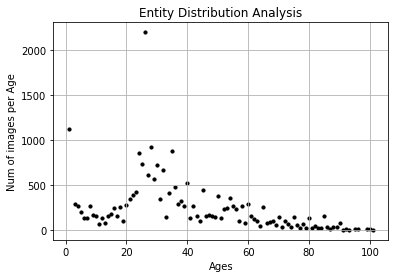

label		Age		Count
0 		 1 		 1123
1 		 3 		 289
2 		 4 		 273
3 		 5 		 196
4 		 6 		 131
5 		 7 		 139
6 		 8 		 263
7 		 9 		 166
8 		 10 		 156
9 		 11 		 65
10 		 12 		 130
11 		 13 		 81
12 		 14 		 157
13 		 15 		 177
14 		 16 		 247
15 		 17 		 158
16 		 18 		 262
17 		 19 		 98
18 		 20 		 284
19 		 21 		 346
20 		 22 		 395
21 		 23 		 426
22 		 24 		 859
23 		 25 		 734
24 		 26 		 2197
25 		 27 		 615
26 		 28 		 918
27 		 29 		 570
28 		 30 		 724
29 		 31 		 350
30 		 32 		 664
31 		 33 		 143
32 		 34 		 409
33 		 35 		 880
34 		 36 		 483
35 		 37 		 293
36 		 38 		 325
37 		 39 		 266
38 		 40 		 526
39 		 41 		 132
40 		 42 		 266
41 		 43 		 157
42 		 44 		 100
43 		 45 		 440
44 		 46 		 153
45 		 47 		 170
46 		 48 		 153
47 		 49 		 148
48 		 50 		 381
49 		 51 		 138
50 		 52 		 232
51 		 53 		 241
52 		 54 		 353
53 		 55 		 268
54 		 56 		 236
55 		 57 		 97
56 		 58 		 271
57 		 59 		 82
58 		 60 		 293
59 		 61 		 161
60 		 62 		 125
61 		 63 		 103
62 		 64 		

In [97]:
dataset_analysis(train_dataset)

**Dataset Loader**

In [98]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

In [99]:
len(train_loader)

182

In [100]:
# t = torch.zeros(NUM_CLASSES-1).float()
# print(type(t))
# print(t.shape)
# print(t)

In [101]:
# logits = 1000000
# logits = logits + t
# print(logits)

In [102]:
# torch.sigmoid(logits)

In [103]:
# t1 = torch.randn(3,3)
# print(t1)
# t2 = torch.sigmoid(t1)
# print(t2)
# t3 = t2 > 0.5
# print(t3)

# torch.sum(t3, 1)

In [104]:
# _, idx = torch.max(t2, dim=1)
# idx

**Model**

**Initialise Model & Optimizer**

In [105]:
# import torchvision.models as models
# from torchvision.models.resnet import ResNet, BasicBlock

# pretrained_model = models.resnet34(pretrained=True)
# class MyResNet34(nn.Module):
#     def __init__(self, pretrained_model):
#         super(MyResNet34, self).__init__()
#         self.pretrained = pretrained_model
#         self.pretrained.fc = nn.Linear(model.fc.in_features, 1, bias = False)
#         self.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES-1).float())
        
#     def forward(self, x):
#         # x = self.conv1(x)
#         # x = self.bn1(x)
#         # x = self.relu(x)
#         # x = self.maxpool(x)

#         # x = self.layer1(x)
#         # x = self.layer2(x)
#         # x = self.layer3(x)
#         # x = self.layer4(x)

#         # x = self.avgpool(x)
#         # x = torch.flatten(x, 1)
#         # logits = self.fc(x)
#         logits = self.pretrained(x)
#         logits = logits + self.linear_1_bias
#         probas = torch.sigmoid(logits) 
#         return logits, probas

In [106]:
# a = MyResNet34(pretrained_model)
# for name,param in a.named_parameters():
#   print(name)

In [107]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1, bias = False)
# model.fc.in_features is 512
model.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES-1).float()) 


params_to_update = model.parameters()
print("Params to learn:")
for name,param in model.named_parameters(): print("\t",name)

model.to(DEVICE)
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
if learning_rate_scheduler:
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Params to learn:
	 linear_1_bias
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.dow

In [108]:
# model.linear_1_bias.shape

In [109]:
# model.linear_1_bias

In [110]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [111]:
# x = torch.rand([1,3,224,224])
# logits = model(x)
# logits = logits + model.linear_1_bias[0:5]
# print(logits)
# print('---------------------------------------')
# t = F.logsigmoid(logits)
# print(t)
# print('---------------------------------------')
# y = torch.tensor([1,1,0,0,0])
# t = t*y
# print(t)
# print('---------------------------------------')
# f = F.logsigmoid(logits) - logits
# print(f)
# print('---------------------------------------')
# y_inv = 1-y
# f = f*y_inv
# print(f)
# print('---------------------------------------')
# total = -torch.sum(t+f)
# print(total)
# print('---------------------------------------')
# imp_weight = 0.997
# total = total*imp

In [112]:
# m = nn.LogSigmoid()
# lol = torch.tensor([-10000000000000.0])
# m(lol)

In [113]:
#logsigmoid range -infinity to 0
def cost_fn(logits, levels, imp):
    val = (-torch.sum((F.logsigmoid(logits)*levels
                      + (F.logsigmoid(logits) - logits)*(1-levels))*imp,
           dim=1))
    return torch.mean(val)

`torch.max()` `returns` highest elements along the dimension and indexes of highest values, here we are only interested to the indexes of highest elements

In [114]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [115]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

**Training**

PyTorch Normally add the previously calculated gradient with the current calculated gradient and then updates the weight. But here we don't want it. That's why we made the previously calculted gradient zero while calculating a new one with `optimizer.zero_grad()`

In [116]:
# x = torch.rand([1,3,224,224])
# logits = model(x)
# logits = logits + model.linear_1_bias[0:5]
# print(logits)
# print('---------------------------------------')
# probas = torch.sigmoid(logits)

In [117]:
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
  train_total_num_correct_preds = train_num_examples = 0

  model.train()
  train_mae=0.0
  for batch_idx, (features, targets, levels) in enumerate(tqdm(train_loader)):

    features = features.to(DEVICE)
    targets = targets.to(DEVICE)
    levels = levels.to(DEVICE)

    # FORWARD AND BACK PROP
    logits = model(features)
    logits = logits + model.linear_1_bias
    cost = cost_fn(logits, levels, imp)
    probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5
    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)

    # _, predicted_labels = torch.max(probas, dim=1)
    optimizer.zero_grad()

    cost.backward()

    # UPDATE MODEL PARAMETERS
    optimizer.step()
    # UPDATE LEARNING RATE
    if learning_rate_scheduler:
      scheduler.step()

    train_total_num_correct_preds += num_correct_preds
    train_num_examples += targets.size(0) 
    train_mae += torch.sum(torch.abs(predicted_labels - targets))
      
  train_mae = train_mae/train_num_examples
  # LOGGING
  print(f'Correct Train Preds: {train_total_num_correct_preds}')
  training_acc = compute_acc(train_total_num_correct_preds, train_num_examples)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  str1 = f'Epoch: {epoch+1}/{EPOCHS} \n'
  str2 = f'--------------------------------------------------------------------\n'
  str3 = f'Training MAE: {format(train_mae, ".3f")}\n'
  str4 = f'Training_Cost: {format(cost, ".3f")}\n'
  str5 = f'Training_Acc: {training_acc}%\n'
  str6 = f'Time elapsed: {time_elapsed}mins\n'

  str = str1+str2+str3+str4+str5+str6
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')
  
  mode_name = f'Epoch_{epoch+1}_model.pt'
  torch.save(model.state_dict(), os.path.join(PATH, mode_name)) # saving the model
  with open(LOGFILE, 'a') as f: f.write(f'---Model Saved---\n')
  print(f'---Model Saved---\n')
    
with open(LOGFILE, 'a') as f: f.write('\n\n############-------Training Completed-------############\n\n')
print("TRAINING COMPLETED")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1123
Epoch: 1/25 
--------------------------------------------------------------------
Training MAE: 27.603
Training_Cost: 46.050
Training_Acc: 4.839%
Time elapsed: 3.529mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1152
Epoch: 2/25 
--------------------------------------------------------------------
Training MAE: 25.442
Training_Cost: 46.439
Training_Acc: 4.964%
Time elapsed: 7.045mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1168
Epoch: 3/25 
--------------------------------------------------------------------
Training MAE: 24.003
Training_Cost: 44.204
Training_Acc: 5.033%
Time elapsed: 10.582mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1207
Epoch: 4/25 
--------------------------------------------------------------------
Training MAE: 22.753
Training_Cost: 40.902
Training_Acc: 5.201%
Time elapsed: 14.091mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1225
Epoch: 5/25 
--------------------------------------------------------------------
Training MAE: 21.314
Training_Cost: 39.448
Training_Acc: 5.279%
Time elapsed: 17.574mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1262
Epoch: 6/25 
--------------------------------------------------------------------
Training MAE: 20.223
Training_Cost: 37.864
Training_Acc: 5.438%
Time elapsed: 20.912mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1321
Epoch: 7/25 
--------------------------------------------------------------------
Training MAE: 18.811
Training_Cost: 33.940
Training_Acc: 5.692%
Time elapsed: 24.245mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1396
Epoch: 8/25 
--------------------------------------------------------------------
Training MAE: 17.414
Training_Cost: 34.510
Training_Acc: 6.015%
Time elapsed: 27.611mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1429
Epoch: 9/25 
--------------------------------------------------------------------
Training MAE: 15.971
Training_Cost: 31.475
Training_Acc: 6.158%
Time elapsed: 31.353mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1603
Epoch: 10/25 
--------------------------------------------------------------------
Training MAE: 14.401
Training_Cost: 33.656
Training_Acc: 6.907%
Time elapsed: 35.130mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1739
Epoch: 11/25 
--------------------------------------------------------------------
Training MAE: 12.810
Training_Cost: 31.957
Training_Acc: 7.493%
Time elapsed: 38.913mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 1943
Epoch: 12/25 
--------------------------------------------------------------------
Training MAE: 11.129
Training_Cost: 30.576
Training_Acc: 8.372%
Time elapsed: 42.691mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2128
Epoch: 13/25 
--------------------------------------------------------------------
Training MAE: 9.913
Training_Cost: 30.315
Training_Acc: 9.170%
Time elapsed: 46.471mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2300
Epoch: 14/25 
--------------------------------------------------------------------
Training MAE: 8.674
Training_Cost: 28.881
Training_Acc: 9.911%
Time elapsed: 50.257mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2499
Epoch: 15/25 
--------------------------------------------------------------------
Training MAE: 7.665
Training_Cost: 26.299
Training_Acc: 10.768%
Time elapsed: 54.039mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2560
Epoch: 16/25 
--------------------------------------------------------------------
Training MAE: 7.091
Training_Cost: 25.737
Training_Acc: 11.031%
Time elapsed: 57.827mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2602
Epoch: 17/25 
--------------------------------------------------------------------
Training MAE: 6.712
Training_Cost: 23.417
Training_Acc: 11.212%
Time elapsed: 61.611mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2536
Epoch: 18/25 
--------------------------------------------------------------------
Training MAE: 6.542
Training_Cost: 21.534
Training_Acc: 10.928%
Time elapsed: 65.401mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2587
Epoch: 19/25 
--------------------------------------------------------------------
Training MAE: 6.346
Training_Cost: 26.111
Training_Acc: 11.147%
Time elapsed: 69.183mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2493
Epoch: 20/25 
--------------------------------------------------------------------
Training MAE: 6.652
Training_Cost: 21.860
Training_Acc: 10.742%
Time elapsed: 72.966mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2530
Epoch: 21/25 
--------------------------------------------------------------------
Training MAE: 6.191
Training_Cost: 24.206
Training_Acc: 10.902%
Time elapsed: 76.756mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2537
Epoch: 22/25 
--------------------------------------------------------------------
Training MAE: 5.950
Training_Cost: 21.672
Training_Acc: 10.932%
Time elapsed: 80.441mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2582
Epoch: 23/25 
--------------------------------------------------------------------
Training MAE: 5.776
Training_Cost: 19.380
Training_Acc: 11.126%
Time elapsed: 83.959mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2577
Epoch: 24/25 
--------------------------------------------------------------------
Training MAE: 5.646
Training_Cost: 21.003
Training_Acc: 11.104%
Time elapsed: 87.453mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 2574
Epoch: 25/25 
--------------------------------------------------------------------
Training MAE: 5.544
Training_Cost: 20.873
Training_Acc: 11.091%
Time elapsed: 90.937mins

---Model Saved---

TRAINING COMPLETED


**Evaluataion**

In [118]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets, levels) in enumerate(data_loader):
          
    targets, features = targets.to(device), features.to(device)
    logits = model(features)
    logits = logits + model.linear_1_bias
    probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5

    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

In [119]:
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

  train_mae, train_mse, train_acc = compute_mae_and_mse(model, train_loader, device=DEVICE)
  str1 = f'Training MAE: {train_mae}\n'
  str2 = f'Training RMSE: {train_mse}\n'
  str3 = f'Training Acc: {train_acc}%\n'
  str = str1+str2+str3

  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')

str = f'Total Elapsed Time: {format(((time.time() - start_time)/60), ".3f")} mins \n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

total_num_correct_preds: 2672
Training MAE: 5.266
Training RMSE: 7.427
Training Acc: 11.514%

Total Elapsed Time: 92.332 mins 



**Saving the Model**

PyTorch: What's the difference between state_dict and parameters()? [link](https://stackoverflow.com/questions/54746829/pytorch-whats-the-difference-between-state-dict-and-parameters)

In [120]:
# model = model.to(torch.device('cpu'))
# torch.save(model.state_dict(), os.path.join(PATH, 'model.pt'))

# CORAL RESNET101

In [121]:
!nvidia-smi

Mon Aug 30 21:08:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    51W / 250W |  13359MiB / 16280MiB |     95%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [122]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# import argparse

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
TRAIN_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/UTKFace_1-101_class-97-label-0-96-final.csv'
IMAGE_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/UTKFace-images'

RANDOM_SEED = 42
MODEL_NAME = "Full-UTK-CORAL_ResNet101-Pretrained-Finetuned_100%-EPOCHS-25-withourLRS"
PATH = "/content/drive/MyDrive/CSE465/Models_and_Logs/" + MODEL_NAME

GRAYSCALE = False
NUM_CLASSES = 97
BATCH_SIZE = 64
EPOCHS = 25
learning_rate = 0.0005
NUM_WORKERS = 0
IMP_WEIGHT = 1
learning_rate_scheduler = False

In [125]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [126]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'training.log')

In [127]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Model Name: {MODEL_NAME}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'Learning Rate: {learning_rate}')
header.append(f'Epochs: {EPOCHS}')
if learning_rate_scheduler:
  header.append(f'Learning Rate Schedule: {learning_rate_scheduler}')

In [128]:
for entry in header:
  print(entry)




Last Run: 2021-08-31 03:08:53.195620+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Model Name: Full-UTK-CORAL_ResNet101-Pretrained-Finetuned_100%-EPOCHS-25-withourLRS
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/Full-UTK-CORAL_ResNet101-Pretrained-Finetuned_100%-EPOCHS-25-withourLRS
-------------------HyperParameters---------------
No. of Classes: 97
Batch size: 64
Grayscale: False
Learning Rate: 0.0005
Epochs: 25


In [129]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

In [130]:
df = pd.read_csv(TRAIN_CSV_PATH)
labels = df['label'].values
del df
labels = torch.tensor(labels, dtype=torch.float)
labels.size()

torch.Size([23207])

In [131]:
uniq = torch.unique(labels) #0-96
num_examples = labels.size(0) #23207

m = torch.zeros(uniq.shape[0]) #tensor of 97 zeros
# j=0
# lol = torch.arange(torch.min(uniq), torch.max(uniq))
# print(lol) #0-95
# x = torch.tensor(labels[labels > j]).size(0)
# print(x) #no. of examples that have ages greater than j
# y = num_examples - labels[labels > j].size(0)
# print(y) #no. of examples have ages less than or equal to j
# a = torch.tensor([x, y]) #a tensor with two elements
# print(a)
# max = torch.max(a)
# print(max) #so samples greater than age 1 are more
# root = torch.sqrt(max.float())
# print(root) # square root of max of a

for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq))):
    m_k = torch.max(torch.tensor([labels[labels > t].size(0), 
                                  num_examples - labels[labels > t].size(0)]))
    m[i] = torch.sqrt(m_k.float())

imp = m/torch.max(m)
print(m)
print(imp)

tensor([148.6069, 147.6313, 146.7038, 146.0342, 145.5850, 145.1069, 144.1978,
        143.6210, 143.0769, 142.8496, 142.3938, 142.1091, 141.5556, 140.9291,
        140.0500, 139.4848, 138.5424, 138.1883, 137.1568, 135.8897, 134.4284,
        132.8345, 129.5608, 126.6965, 117.7073, 115.0652, 111.0045, 108.4066,
        110.3585, 111.9330, 114.8608, 115.4816, 117.2391, 120.9339, 122.9146,
        124.1008, 125.4034, 126.4595, 128.5224, 129.0349, 130.0615, 130.6637,
        131.0458, 132.7140, 133.2892, 133.9254, 134.4953, 135.0444, 136.4478,
        136.9525, 137.7970, 138.6687, 139.9357, 140.8900, 141.7251, 142.0669,
        143.0175, 143.3039, 144.3226, 144.8793, 145.3100, 145.6640, 145.8355,
        146.7208, 146.9830, 147.3024, 147.6415, 147.8310, 148.3273, 148.4385,
        148.7683, 148.9799, 149.0872, 149.5827, 149.7765, 149.8699, 150.1000,
        150.1766, 150.6187, 150.6917, 150.8244, 150.8841, 150.9636, 151.4761,
        151.5916, 151.6245, 151.7366, 151.8453, 152.1151, 152.12

In [132]:
def task_importance_weights(label_array):
    uniq = torch.unique(label_array)
    num_examples = label_array.size(0)

    m = torch.zeros(uniq.shape[0])

    for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq))):
        m_k = torch.max(torch.tensor([label_array[label_array > t].size(0), 
                                      num_examples - label_array[label_array > t].size(0)]))
        m[i] = torch.sqrt(m_k.float())

    imp = m/torch.max(m)
    return imp

In [133]:
# Data-specific scheme
if not IMP_WEIGHT:
    imp = torch.ones(NUM_CLASSES-1, dtype=torch.float)
elif IMP_WEIGHT == 1:
    imp = task_importance_weights(labels)
    imp = imp[0:NUM_CLASSES-1]
else:
    raise ValueError('Incorrect importance weight parameter.')
imp = imp.to(DEVICE)

 **Dataset**

In [134]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""

    def __init__(self, csv_path, img_dir, transform=None, items=None):
        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')

        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        # img = img.convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        levels = [1]*label + [0]*(NUM_CLASSES - 1 - label) #converting labels to levels..so if age is 22, 22 ones and (96-22) zeros
        levels = torch.tensor(levels, dtype=torch.float32)

        return img, label, levels
        
    def __len__(self):
        return self.y.shape[0]

In [135]:
custom_transform_train = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.RandomCrop((224, 224)),
                                       transforms.ToTensor(),
                                       ])

train_dataset = UTKFaceDataset(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH,
                               transform=custom_transform_train,
                               items = None
                               )

# image, label, level = train_dataset.__getitem__(0)
# label, level, level.shape

**Dataset Entity Distribution Analysis**

In [136]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

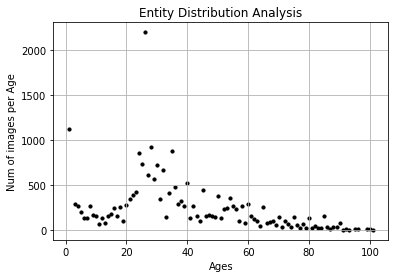

label		Age		Count
0 		 1 		 1123
1 		 3 		 289
2 		 4 		 273
3 		 5 		 196
4 		 6 		 131
5 		 7 		 139
6 		 8 		 263
7 		 9 		 166
8 		 10 		 156
9 		 11 		 65
10 		 12 		 130
11 		 13 		 81
12 		 14 		 157
13 		 15 		 177
14 		 16 		 247
15 		 17 		 158
16 		 18 		 262
17 		 19 		 98
18 		 20 		 284
19 		 21 		 346
20 		 22 		 395
21 		 23 		 426
22 		 24 		 859
23 		 25 		 734
24 		 26 		 2197
25 		 27 		 615
26 		 28 		 918
27 		 29 		 570
28 		 30 		 724
29 		 31 		 350
30 		 32 		 664
31 		 33 		 143
32 		 34 		 409
33 		 35 		 880
34 		 36 		 483
35 		 37 		 293
36 		 38 		 325
37 		 39 		 266
38 		 40 		 526
39 		 41 		 132
40 		 42 		 266
41 		 43 		 157
42 		 44 		 100
43 		 45 		 440
44 		 46 		 153
45 		 47 		 170
46 		 48 		 153
47 		 49 		 148
48 		 50 		 381
49 		 51 		 138
50 		 52 		 232
51 		 53 		 241
52 		 54 		 353
53 		 55 		 268
54 		 56 		 236
55 		 57 		 97
56 		 58 		 271
57 		 59 		 82
58 		 60 		 293
59 		 61 		 161
60 		 62 		 125
61 		 63 		 103
62 		 64 		

In [137]:
dataset_analysis(train_dataset)

**Dataset Loader**

In [138]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

In [139]:
len(train_loader)

363

In [140]:
# t = torch.zeros(NUM_CLASSES-1).float()
# print(type(t))
# print(t.shape)
# print(t)

In [141]:
# logits = 1000000
# logits = logits + t
# print(logits)

In [142]:
# torch.sigmoid(logits)

In [143]:
# t1 = torch.randn(3,3)
# print(t1)
# t2 = torch.sigmoid(t1)
# print(t2)
# t3 = t2 > 0.5
# print(t3)

# torch.sum(t3, 1)

In [144]:
# _, idx = torch.max(t2, dim=1)
# idx

**Model**

**Initialise Model & Optimizer**

In [145]:
# import torchvision.models as models
# from torchvision.models.resnet import ResNet, BasicBlock

# pretrained_model = models.resnet34(pretrained=True)
# class MyResNet34(nn.Module):
#     def __init__(self, pretrained_model):
#         super(MyResNet34, self).__init__()
#         self.pretrained = pretrained_model
#         self.pretrained.fc = nn.Linear(model.fc.in_features, 1, bias = False)
#         self.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES-1).float())
        
#     def forward(self, x):
#         # x = self.conv1(x)
#         # x = self.bn1(x)
#         # x = self.relu(x)
#         # x = self.maxpool(x)

#         # x = self.layer1(x)
#         # x = self.layer2(x)
#         # x = self.layer3(x)
#         # x = self.layer4(x)

#         # x = self.avgpool(x)
#         # x = torch.flatten(x, 1)
#         # logits = self.fc(x)
#         logits = self.pretrained(x)
#         logits = logits + self.linear_1_bias
#         probas = torch.sigmoid(logits) 
#         return logits, probas

In [146]:
# a = MyResNet34(pretrained_model)
# for name,param in a.named_parameters():
#   print(name)

In [147]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = models.resnet101(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1, bias = False)
# model.fc.in_features is 512
model.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES-1).float()) 


params_to_update = model.parameters()
print("Params to learn:")
for name,param in model.named_parameters(): print("\t",name)

model.to(DEVICE)
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
if learning_rate_scheduler:
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Params to learn:
	 linear_1_bias
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.dow

In [148]:
# model.linear_1_bias.shape

In [149]:
# model.linear_1_bias

In [150]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [151]:
# x = torch.rand([1,3,224,224])
# logits = model(x)
# logits = logits + model.linear_1_bias[0:5]
# print(logits)
# print('---------------------------------------')
# t = F.logsigmoid(logits)
# print(t)
# print('---------------------------------------')
# y = torch.tensor([1,1,0,0,0])
# t = t*y
# print(t)
# print('---------------------------------------')
# f = F.logsigmoid(logits) - logits
# print(f)
# print('---------------------------------------')
# y_inv = 1-y
# f = f*y_inv
# print(f)
# print('---------------------------------------')
# total = -torch.sum(t+f)
# print(total)
# print('---------------------------------------')
# imp_weight = 0.997
# total = total*imp

In [152]:
# m = nn.LogSigmoid()
# lol = torch.tensor([-10000000000000.0])
# m(lol)

In [153]:
#logsigmoid range -infinity to 0
def cost_fn(logits, levels, imp):
    val = (-torch.sum((F.logsigmoid(logits)*levels
                      + (F.logsigmoid(logits) - logits)*(1-levels))*imp,
           dim=1))
    return torch.mean(val)

`torch.max()` `returns` highest elements along the dimension and indexes of highest values, here we are only interested to the indexes of highest elements

In [154]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [155]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

**Training**

PyTorch Normally add the previously calculated gradient with the current calculated gradient and then updates the weight. But here we don't want it. That's why we made the previously calculted gradient zero while calculating a new one with `optimizer.zero_grad()`

In [156]:
# x = torch.rand([1,3,224,224])
# logits = model(x)
# logits = logits + model.linear_1_bias[0:5]
# print(logits)
# print('---------------------------------------')
# probas = torch.sigmoid(logits)

In [157]:
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
  train_total_num_correct_preds = train_num_examples = 0

  model.train()
  train_mae=0.0
  for batch_idx, (features, targets, levels) in enumerate(tqdm(train_loader)):

    features = features.to(DEVICE)
    targets = targets.to(DEVICE)
    levels = levels.to(DEVICE)

    # FORWARD AND BACK PROP
    logits = model(features)
    logits = logits + model.linear_1_bias
    cost = cost_fn(logits, levels, imp)
    probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5
    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)

    # _, predicted_labels = torch.max(probas, dim=1)
    optimizer.zero_grad()

    cost.backward()

    # UPDATE MODEL PARAMETERS
    optimizer.step()
    # UPDATE LEARNING RATE
    if learning_rate_scheduler:
      scheduler.step()

    train_total_num_correct_preds += num_correct_preds
    train_num_examples += targets.size(0) 
    train_mae += torch.sum(torch.abs(predicted_labels - targets))
      
  train_mae = train_mae/train_num_examples
  # LOGGING
  print(f'Correct Train Preds: {train_total_num_correct_preds}')
  training_acc = compute_acc(train_total_num_correct_preds, train_num_examples)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  str1 = f'Epoch: {epoch+1}/{EPOCHS} \n'
  str2 = f'--------------------------------------------------------------------\n'
  str3 = f'Training MAE: {format(train_mae, ".3f")}\n'
  str4 = f'Training_Cost: {format(cost, ".3f")}\n'
  str5 = f'Training_Acc: {training_acc}%\n'
  str6 = f'Time elapsed: {time_elapsed}mins\n'

  str = str1+str2+str3+str4+str5+str6
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')
  
  mode_name = f'Epoch_{epoch+1}_model.pt'
  torch.save(model.state_dict(), os.path.join(PATH, mode_name)) # saving the model
  with open(LOGFILE, 'a') as f: f.write(f'---Model Saved---\n')
  print(f'---Model Saved---\n')
    
with open(LOGFILE, 'a') as f: f.write('\n\n############-------Training Completed-------############\n\n')
print("TRAINING COMPLETED")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 1151
Epoch: 1/25 
--------------------------------------------------------------------
Training MAE: 26.885
Training_Cost: 41.012
Training_Acc: 4.960%
Time elapsed: 5.054mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 1180
Epoch: 2/25 
--------------------------------------------------------------------
Training MAE: 23.704
Training_Cost: 40.594
Training_Acc: 5.085%
Time elapsed: 10.139mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 1261
Epoch: 3/25 
--------------------------------------------------------------------
Training MAE: 21.030
Training_Cost: 38.932
Training_Acc: 5.434%
Time elapsed: 15.213mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 1399
Epoch: 4/25 
--------------------------------------------------------------------
Training MAE: 18.274
Training_Cost: 34.117
Training_Acc: 6.028%
Time elapsed: 20.291mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 1557
Epoch: 5/25 
--------------------------------------------------------------------
Training MAE: 15.383
Training_Cost: 32.611
Training_Acc: 6.709%
Time elapsed: 25.378mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 1841
Epoch: 6/25 
--------------------------------------------------------------------
Training MAE: 12.504
Training_Cost: 29.559
Training_Acc: 7.933%
Time elapsed: 30.464mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2116
Epoch: 7/25 
--------------------------------------------------------------------
Training MAE: 9.916
Training_Cost: 28.198
Training_Acc: 9.118%
Time elapsed: 35.554mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2314
Epoch: 8/25 
--------------------------------------------------------------------
Training MAE: 8.603
Training_Cost: 26.107
Training_Acc: 9.971%
Time elapsed: 40.630mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2425
Epoch: 9/25 
--------------------------------------------------------------------
Training MAE: 7.545
Training_Cost: 23.547
Training_Acc: 10.449%
Time elapsed: 45.718mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2470
Epoch: 10/25 
--------------------------------------------------------------------
Training MAE: 7.001
Training_Cost: 23.363
Training_Acc: 10.643%
Time elapsed: 50.796mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2401
Epoch: 11/25 
--------------------------------------------------------------------
Training MAE: 6.728
Training_Cost: 22.325
Training_Acc: 10.346%
Time elapsed: 55.883mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2509
Epoch: 12/25 
--------------------------------------------------------------------
Training MAE: 6.476
Training_Cost: 20.541
Training_Acc: 10.811%
Time elapsed: 60.972mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2465
Epoch: 13/25 
--------------------------------------------------------------------
Training MAE: 6.231
Training_Cost: 19.630
Training_Acc: 10.622%
Time elapsed: 66.061mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2588
Epoch: 14/25 
--------------------------------------------------------------------
Training MAE: 6.124
Training_Cost: 19.332
Training_Acc: 11.152%
Time elapsed: 71.151mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2530
Epoch: 15/25 
--------------------------------------------------------------------
Training MAE: 5.827
Training_Cost: 16.245
Training_Acc: 10.902%
Time elapsed: 76.242mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2694
Epoch: 16/25 
--------------------------------------------------------------------
Training MAE: 5.623
Training_Cost: 17.258
Training_Acc: 11.609%
Time elapsed: 81.325mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2718
Epoch: 17/25 
--------------------------------------------------------------------
Training MAE: 5.501
Training_Cost: 15.848
Training_Acc: 11.712%
Time elapsed: 86.414mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2864
Epoch: 18/25 
--------------------------------------------------------------------
Training MAE: 5.291
Training_Cost: 14.775
Training_Acc: 12.341%
Time elapsed: 91.497mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2886
Epoch: 19/25 
--------------------------------------------------------------------
Training MAE: 5.105
Training_Cost: 17.947
Training_Acc: 12.436%
Time elapsed: 96.590mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2929
Epoch: 20/25 
--------------------------------------------------------------------
Training MAE: 4.878
Training_Cost: 16.639
Training_Acc: 12.621%
Time elapsed: 101.680mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 3075
Epoch: 21/25 
--------------------------------------------------------------------
Training MAE: 4.773
Training_Cost: 15.780
Training_Acc: 13.250%
Time elapsed: 106.774mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2996
Epoch: 22/25 
--------------------------------------------------------------------
Training MAE: 4.773
Training_Cost: 14.179
Training_Acc: 12.910%
Time elapsed: 111.875mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 3270
Epoch: 23/25 
--------------------------------------------------------------------
Training MAE: 4.404
Training_Cost: 13.908
Training_Acc: 14.091%
Time elapsed: 116.973mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 3252
Epoch: 24/25 
--------------------------------------------------------------------
Training MAE: 4.319
Training_Cost: 10.909
Training_Acc: 14.013%
Time elapsed: 122.068mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 3314
Epoch: 25/25 
--------------------------------------------------------------------
Training MAE: 4.171
Training_Cost: 11.279
Training_Acc: 14.280%
Time elapsed: 127.158mins

---Model Saved---

TRAINING COMPLETED


**Evaluataion**

In [158]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets, levels) in enumerate(data_loader):
          
    targets, features = targets.to(device), features.to(device)
    logits = model(features)
    logits = logits + model.linear_1_bias
    probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5

    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

In [159]:
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

  train_mae, train_mse, train_acc = compute_mae_and_mse(model, train_loader, device=DEVICE)
  str1 = f'Training MAE: {train_mae}\n'
  str2 = f'Training RMSE: {train_mse}\n'
  str3 = f'Training Acc: {train_acc}%\n'
  str = str1+str2+str3

  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')

str = f'Total Elapsed Time: {format(((time.time() - start_time)/60), ".3f")} mins \n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

total_num_correct_preds: 3031
Training MAE: 5.714
Training RMSE: 7.750
Training Acc: 13.061%

Total Elapsed Time: 128.610 mins 



**Saving the Model**

PyTorch: What's the difference between state_dict and parameters()? [link](https://stackoverflow.com/questions/54746829/pytorch-whats-the-difference-between-state-dict-and-parameters)

In [160]:
# model = model.to(torch.device('cpu'))
# torch.save(model.state_dict(), os.path.join(PATH, 'model.pt'))

# CORAL RESNET152

In [161]:
!nvidia-smi

Mon Aug 30 23:17:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    53W / 250W |  13497MiB / 16280MiB |     97%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [162]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# import argparse

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

In [163]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [164]:
TRAIN_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/UTKFace_1-101_class-97-label-0-96-final.csv'
IMAGE_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/UTKFace-images'

RANDOM_SEED = 42
MODEL_NAME = "Full-UTK-CORAL_ResNet152-Pretrained-Finetuned_100%-EPOCHS-25-withourLRS"
PATH = "/content/drive/MyDrive/CSE465/Models_and_Logs/" + MODEL_NAME

GRAYSCALE = False
NUM_CLASSES = 97
BATCH_SIZE = 64
EPOCHS = 25
learning_rate = 0.0005
NUM_WORKERS = 0
IMP_WEIGHT = 1
learning_rate_scheduler = False

In [165]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [166]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'training.log')

In [167]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Model Name: {MODEL_NAME}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'Learning Rate: {learning_rate}')
header.append(f'Epochs: {EPOCHS}')
if learning_rate_scheduler:
  header.append(f'Learning Rate Schedule: {learning_rate_scheduler}')

In [168]:
for entry in header:
  print(entry)




Last Run: 2021-08-31 05:17:37.367945+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Model Name: Full-UTK-CORAL_ResNet152-Pretrained-Finetuned_100%-EPOCHS-25-withourLRS
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/Full-UTK-CORAL_ResNet152-Pretrained-Finetuned_100%-EPOCHS-25-withourLRS
-------------------HyperParameters---------------
No. of Classes: 97
Batch size: 64
Grayscale: False
Learning Rate: 0.0005
Epochs: 25


In [169]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

In [170]:
df = pd.read_csv(TRAIN_CSV_PATH)
labels = df['label'].values
del df
labels = torch.tensor(labels, dtype=torch.float)
labels.size()

torch.Size([23207])

In [171]:
uniq = torch.unique(labels) #0-96
num_examples = labels.size(0) #23207

m = torch.zeros(uniq.shape[0]) #tensor of 97 zeros
# j=0
# lol = torch.arange(torch.min(uniq), torch.max(uniq))
# print(lol) #0-95
# x = torch.tensor(labels[labels > j]).size(0)
# print(x) #no. of examples that have ages greater than j
# y = num_examples - labels[labels > j].size(0)
# print(y) #no. of examples have ages less than or equal to j
# a = torch.tensor([x, y]) #a tensor with two elements
# print(a)
# max = torch.max(a)
# print(max) #so samples greater than age 1 are more
# root = torch.sqrt(max.float())
# print(root) # square root of max of a

for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq))):
    m_k = torch.max(torch.tensor([labels[labels > t].size(0), 
                                  num_examples - labels[labels > t].size(0)]))
    m[i] = torch.sqrt(m_k.float())

imp = m/torch.max(m)
print(m)
print(imp)

tensor([148.6069, 147.6313, 146.7038, 146.0342, 145.5850, 145.1069, 144.1978,
        143.6210, 143.0769, 142.8496, 142.3938, 142.1091, 141.5556, 140.9291,
        140.0500, 139.4848, 138.5424, 138.1883, 137.1568, 135.8897, 134.4284,
        132.8345, 129.5608, 126.6965, 117.7073, 115.0652, 111.0045, 108.4066,
        110.3585, 111.9330, 114.8608, 115.4816, 117.2391, 120.9339, 122.9146,
        124.1008, 125.4034, 126.4595, 128.5224, 129.0349, 130.0615, 130.6637,
        131.0458, 132.7140, 133.2892, 133.9254, 134.4953, 135.0444, 136.4478,
        136.9525, 137.7970, 138.6687, 139.9357, 140.8900, 141.7251, 142.0669,
        143.0175, 143.3039, 144.3226, 144.8793, 145.3100, 145.6640, 145.8355,
        146.7208, 146.9830, 147.3024, 147.6415, 147.8310, 148.3273, 148.4385,
        148.7683, 148.9799, 149.0872, 149.5827, 149.7765, 149.8699, 150.1000,
        150.1766, 150.6187, 150.6917, 150.8244, 150.8841, 150.9636, 151.4761,
        151.5916, 151.6245, 151.7366, 151.8453, 152.1151, 152.12

In [172]:
def task_importance_weights(label_array):
    uniq = torch.unique(label_array)
    num_examples = label_array.size(0)

    m = torch.zeros(uniq.shape[0])

    for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq))):
        m_k = torch.max(torch.tensor([label_array[label_array > t].size(0), 
                                      num_examples - label_array[label_array > t].size(0)]))
        m[i] = torch.sqrt(m_k.float())

    imp = m/torch.max(m)
    return imp

In [173]:
# Data-specific scheme
if not IMP_WEIGHT:
    imp = torch.ones(NUM_CLASSES-1, dtype=torch.float)
elif IMP_WEIGHT == 1:
    imp = task_importance_weights(labels)
    imp = imp[0:NUM_CLASSES-1]
else:
    raise ValueError('Incorrect importance weight parameter.')
imp = imp.to(DEVICE)

 **Dataset**

In [174]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""

    def __init__(self, csv_path, img_dir, transform=None, items=None):
        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')

        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        # img = img.convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        levels = [1]*label + [0]*(NUM_CLASSES - 1 - label) #converting labels to levels..so if age is 22, 22 ones and (96-22) zeros
        levels = torch.tensor(levels, dtype=torch.float32)

        return img, label, levels
        
    def __len__(self):
        return self.y.shape[0]

In [175]:
custom_transform_train = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.RandomCrop((224, 224)),
                                       transforms.ToTensor(),
                                       ])

train_dataset = UTKFaceDataset(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH,
                               transform=custom_transform_train,
                               items = None
                               )

# image, label, level = train_dataset.__getitem__(0)
# label, level, level.shape

**Dataset Entity Distribution Analysis**

In [176]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

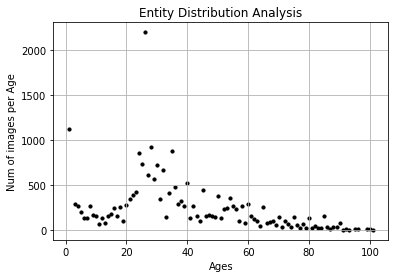

label		Age		Count
0 		 1 		 1123
1 		 3 		 289
2 		 4 		 273
3 		 5 		 196
4 		 6 		 131
5 		 7 		 139
6 		 8 		 263
7 		 9 		 166
8 		 10 		 156
9 		 11 		 65
10 		 12 		 130
11 		 13 		 81
12 		 14 		 157
13 		 15 		 177
14 		 16 		 247
15 		 17 		 158
16 		 18 		 262
17 		 19 		 98
18 		 20 		 284
19 		 21 		 346
20 		 22 		 395
21 		 23 		 426
22 		 24 		 859
23 		 25 		 734
24 		 26 		 2197
25 		 27 		 615
26 		 28 		 918
27 		 29 		 570
28 		 30 		 724
29 		 31 		 350
30 		 32 		 664
31 		 33 		 143
32 		 34 		 409
33 		 35 		 880
34 		 36 		 483
35 		 37 		 293
36 		 38 		 325
37 		 39 		 266
38 		 40 		 526
39 		 41 		 132
40 		 42 		 266
41 		 43 		 157
42 		 44 		 100
43 		 45 		 440
44 		 46 		 153
45 		 47 		 170
46 		 48 		 153
47 		 49 		 148
48 		 50 		 381
49 		 51 		 138
50 		 52 		 232
51 		 53 		 241
52 		 54 		 353
53 		 55 		 268
54 		 56 		 236
55 		 57 		 97
56 		 58 		 271
57 		 59 		 82
58 		 60 		 293
59 		 61 		 161
60 		 62 		 125
61 		 63 		 103
62 		 64 		

In [177]:
dataset_analysis(train_dataset)

**Dataset Loader**

In [178]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

In [179]:
len(train_loader)

363

In [180]:
# t = torch.zeros(NUM_CLASSES-1).float()
# print(type(t))
# print(t.shape)
# print(t)

In [181]:
# logits = 1000000
# logits = logits + t
# print(logits)

In [182]:
# torch.sigmoid(logits)

In [183]:
# t1 = torch.randn(3,3)
# print(t1)
# t2 = torch.sigmoid(t1)
# print(t2)
# t3 = t2 > 0.5
# print(t3)

# torch.sum(t3, 1)

In [184]:
# _, idx = torch.max(t2, dim=1)
# idx

**Model**

**Initialise Model & Optimizer**

In [185]:
# import torchvision.models as models
# from torchvision.models.resnet import ResNet, BasicBlock

# pretrained_model = models.resnet34(pretrained=True)
# class MyResNet34(nn.Module):
#     def __init__(self, pretrained_model):
#         super(MyResNet34, self).__init__()
#         self.pretrained = pretrained_model
#         self.pretrained.fc = nn.Linear(model.fc.in_features, 1, bias = False)
#         self.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES-1).float())
        
#     def forward(self, x):
#         # x = self.conv1(x)
#         # x = self.bn1(x)
#         # x = self.relu(x)
#         # x = self.maxpool(x)

#         # x = self.layer1(x)
#         # x = self.layer2(x)
#         # x = self.layer3(x)
#         # x = self.layer4(x)

#         # x = self.avgpool(x)
#         # x = torch.flatten(x, 1)
#         # logits = self.fc(x)
#         logits = self.pretrained(x)
#         logits = logits + self.linear_1_bias
#         probas = torch.sigmoid(logits) 
#         return logits, probas

In [186]:
# a = MyResNet34(pretrained_model)
# for name,param in a.named_parameters():
#   print(name)

In [187]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = models.resnet152(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1, bias = False)
# model.fc.in_features is 512
model.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES-1).float()) 


params_to_update = model.parameters()
print("Params to learn:")
for name,param in model.named_parameters(): print("\t",name)

model.to(DEVICE)
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
if learning_rate_scheduler:
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Params to learn:
	 linear_1_bias
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.dow

In [188]:
# model.linear_1_bias.shape

In [189]:
# model.linear_1_bias

In [190]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [191]:
# x = torch.rand([1,3,224,224])
# logits = model(x)
# logits = logits + model.linear_1_bias[0:5]
# print(logits)
# print('---------------------------------------')
# t = F.logsigmoid(logits)
# print(t)
# print('---------------------------------------')
# y = torch.tensor([1,1,0,0,0])
# t = t*y
# print(t)
# print('---------------------------------------')
# f = F.logsigmoid(logits) - logits
# print(f)
# print('---------------------------------------')
# y_inv = 1-y
# f = f*y_inv
# print(f)
# print('---------------------------------------')
# total = -torch.sum(t+f)
# print(total)
# print('---------------------------------------')
# imp_weight = 0.997
# total = total*imp

In [192]:
# m = nn.LogSigmoid()
# lol = torch.tensor([-10000000000000.0])
# m(lol)

In [193]:
#logsigmoid range -infinity to 0
def cost_fn(logits, levels, imp):
    val = (-torch.sum((F.logsigmoid(logits)*levels
                      + (F.logsigmoid(logits) - logits)*(1-levels))*imp,
           dim=1))
    return torch.mean(val)

`torch.max()` `returns` highest elements along the dimension and indexes of highest values, here we are only interested to the indexes of highest elements

In [194]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [195]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

**Training**

PyTorch Normally add the previously calculated gradient with the current calculated gradient and then updates the weight. But here we don't want it. That's why we made the previously calculted gradient zero while calculating a new one with `optimizer.zero_grad()`

In [196]:
# x = torch.rand([1,3,224,224])
# logits = model(x)
# logits = logits + model.linear_1_bias[0:5]
# print(logits)
# print('---------------------------------------')
# probas = torch.sigmoid(logits)

In [197]:
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
  train_total_num_correct_preds = train_num_examples = 0

  model.train()
  train_mae=0.0
  for batch_idx, (features, targets, levels) in enumerate(tqdm(train_loader)):

    features = features.to(DEVICE)
    targets = targets.to(DEVICE)
    levels = levels.to(DEVICE)

    # FORWARD AND BACK PROP
    logits = model(features)
    logits = logits + model.linear_1_bias
    cost = cost_fn(logits, levels, imp)
    probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5
    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)

    # _, predicted_labels = torch.max(probas, dim=1)
    optimizer.zero_grad()

    cost.backward()

    # UPDATE MODEL PARAMETERS
    optimizer.step()
    # UPDATE LEARNING RATE
    if learning_rate_scheduler:
      scheduler.step()

    train_total_num_correct_preds += num_correct_preds
    train_num_examples += targets.size(0) 
    train_mae += torch.sum(torch.abs(predicted_labels - targets))
      
  train_mae = train_mae/train_num_examples
  # LOGGING
  print(f'Correct Train Preds: {train_total_num_correct_preds}')
  training_acc = compute_acc(train_total_num_correct_preds, train_num_examples)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  str1 = f'Epoch: {epoch+1}/{EPOCHS} \n'
  str2 = f'--------------------------------------------------------------------\n'
  str3 = f'Training MAE: {format(train_mae, ".3f")}\n'
  str4 = f'Training_Cost: {format(cost, ".3f")}\n'
  str5 = f'Training_Acc: {training_acc}%\n'
  str6 = f'Time elapsed: {time_elapsed}mins\n'

  str = str1+str2+str3+str4+str5+str6
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')
  
  mode_name = f'Epoch_{epoch+1}_model.pt'
  torch.save(model.state_dict(), os.path.join(PATH, mode_name)) # saving the model
  with open(LOGFILE, 'a') as f: f.write(f'---Model Saved---\n')
  print(f'---Model Saved---\n')
    
with open(LOGFILE, 'a') as f: f.write('\n\n############-------Training Completed-------############\n\n')
print("TRAINING COMPLETED")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 1142
Epoch: 1/25 
--------------------------------------------------------------------
Training MAE: 27.034
Training_Cost: 45.292
Training_Acc: 4.921%
Time elapsed: 6.645mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 1183
Epoch: 2/25 
--------------------------------------------------------------------
Training MAE: 23.837
Training_Cost: 38.970
Training_Acc: 5.098%
Time elapsed: 13.295mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 1255
Epoch: 3/25 
--------------------------------------------------------------------
Training MAE: 21.080
Training_Cost: 35.918
Training_Acc: 5.408%
Time elapsed: 19.948mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 1357
Epoch: 4/25 
--------------------------------------------------------------------
Training MAE: 18.464
Training_Cost: 31.249
Training_Acc: 5.847%
Time elapsed: 26.590mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 1562
Epoch: 5/25 
--------------------------------------------------------------------
Training MAE: 15.463
Training_Cost: 34.956
Training_Acc: 6.731%
Time elapsed: 33.236mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 1861
Epoch: 6/25 
--------------------------------------------------------------------
Training MAE: 12.279
Training_Cost: 30.759
Training_Acc: 8.019%
Time elapsed: 39.892mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2180
Epoch: 7/25 
--------------------------------------------------------------------
Training MAE: 9.814
Training_Cost: 26.239
Training_Acc: 9.394%
Time elapsed: 46.545mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2356
Epoch: 8/25 
--------------------------------------------------------------------
Training MAE: 8.179
Training_Cost: 27.597
Training_Acc: 10.152%
Time elapsed: 53.218mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2494
Epoch: 9/25 
--------------------------------------------------------------------
Training MAE: 7.364
Training_Cost: 23.487
Training_Acc: 10.747%
Time elapsed: 59.853mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2458
Epoch: 10/25 
--------------------------------------------------------------------
Training MAE: 7.031
Training_Cost: 24.590
Training_Acc: 10.592%
Time elapsed: 66.500mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2432
Epoch: 11/25 
--------------------------------------------------------------------
Training MAE: 6.766
Training_Cost: 20.894
Training_Acc: 10.480%
Time elapsed: 73.146mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2403
Epoch: 12/25 
--------------------------------------------------------------------
Training MAE: 6.394
Training_Cost: 22.077
Training_Acc: 10.355%
Time elapsed: 79.804mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2548
Epoch: 13/25 
--------------------------------------------------------------------
Training MAE: 6.260
Training_Cost: 21.202
Training_Acc: 10.979%
Time elapsed: 86.452mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2563
Epoch: 14/25 
--------------------------------------------------------------------
Training MAE: 6.116
Training_Cost: 20.640
Training_Acc: 11.044%
Time elapsed: 93.115mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2599
Epoch: 15/25 
--------------------------------------------------------------------
Training MAE: 5.763
Training_Cost: 16.305
Training_Acc: 11.199%
Time elapsed: 99.770mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2652
Epoch: 16/25 
--------------------------------------------------------------------
Training MAE: 5.812
Training_Cost: 17.044
Training_Acc: 11.428%
Time elapsed: 106.424mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2702
Epoch: 17/25 
--------------------------------------------------------------------
Training MAE: 5.595
Training_Cost: 18.030
Training_Acc: 11.643%
Time elapsed: 113.097mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2793
Epoch: 18/25 
--------------------------------------------------------------------
Training MAE: 5.244
Training_Cost: 15.335
Training_Acc: 12.035%
Time elapsed: 119.769mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2891
Epoch: 19/25 
--------------------------------------------------------------------
Training MAE: 5.016
Training_Cost: 16.572
Training_Acc: 12.457%
Time elapsed: 126.415mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 2959
Epoch: 20/25 
--------------------------------------------------------------------
Training MAE: 4.877
Training_Cost: 15.233
Training_Acc: 12.750%
Time elapsed: 133.055mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 3015
Epoch: 21/25 
--------------------------------------------------------------------
Training MAE: 4.770
Training_Cost: 13.479
Training_Acc: 12.992%
Time elapsed: 139.717mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 3165
Epoch: 22/25 
--------------------------------------------------------------------
Training MAE: 4.521
Training_Cost: 13.099
Training_Acc: 13.638%
Time elapsed: 146.361mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 3225
Epoch: 23/25 
--------------------------------------------------------------------
Training MAE: 4.400
Training_Cost: 13.953
Training_Acc: 13.897%
Time elapsed: 153.017mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 3267
Epoch: 24/25 
--------------------------------------------------------------------
Training MAE: 4.297
Training_Cost: 14.038
Training_Acc: 14.078%
Time elapsed: 159.667mins

---Model Saved---



  0%|          | 0/363 [00:00<?, ?it/s]

Correct Train Preds: 3355
Epoch: 25/25 
--------------------------------------------------------------------
Training MAE: 4.169
Training_Cost: 13.094
Training_Acc: 14.457%
Time elapsed: 166.330mins

---Model Saved---

TRAINING COMPLETED


**Evaluataion**

In [198]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets, levels) in enumerate(data_loader):
          
    targets, features = targets.to(device), features.to(device)
    logits = model(features)
    logits = logits + model.linear_1_bias
    probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5

    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

In [199]:
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

  train_mae, train_mse, train_acc = compute_mae_and_mse(model, train_loader, device=DEVICE)
  str1 = f'Training MAE: {train_mae}\n'
  str2 = f'Training RMSE: {train_mse}\n'
  str3 = f'Training Acc: {train_acc}%\n'
  str = str1+str2+str3

  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')

str = f'Total Elapsed Time: {format(((time.time() - start_time)/60), ".3f")} mins \n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

total_num_correct_preds: 3615
Training MAE: 3.986
Training RMSE: 5.466
Training Acc: 15.577%

Total Elapsed Time: 167.816 mins 



**Saving the Model**

PyTorch: What's the difference between state_dict and parameters()? [link](https://stackoverflow.com/questions/54746829/pytorch-whats-the-difference-between-state-dict-and-parameters)

In [200]:
# model = model.to(torch.device('cpu'))
# torch.save(model.state_dict(), os.path.join(PATH, 'model.pt'))

# RESNET18

In [201]:
!nvidia-smi

Tue Aug 31 02:05:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    52W / 250W |  13619MiB / 16280MiB |     48%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [202]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)

import copy
import datetime
import pytz

In [203]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [204]:
TRAIN_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/UTKFace_1-101_class-97-label-0-96-final.csv'
IMAGE_PATH_TRAIN = '/content/drive/MyDrive/CSE465/datasets/UTKFace/UTKFace-images'

RANDOM_SEED = 42
MODEL_NAME = "Full-UTK-CE_ResNet18-Pretrained-Finetuned_100%_EPOCHS-25-withoutLRS"
PATH = '/content/drive/MyDrive/CSE465/Models_and_Logs/' + MODEL_NAME

GRAYSCALE = False
NUM_CLASSES = 97
BATCH_SIZE = 128 #64
EPOCHS = 25
learning_rate = 0.0005
NUM_WORKERS = 0
learning_rate_scheduler = False

In [205]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [206]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'training.log')

In [207]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Model Name: {MODEL_NAME}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'Learning Rate: {learning_rate}')
header.append(f'Epochs: {EPOCHS}')
if learning_rate_scheduler:
  header.append(f'Learning Rate Schedule: {learning_rate_scheduler}')

In [208]:
for entry in header:
  print(entry)




Last Run: 2021-08-31 08:05:36.038468+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Model Name: Full-UTK-CE_ResNet18-Pretrained-Finetuned_100%_EPOCHS-25-withoutLRS
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/Full-UTK-CE_ResNet18-Pretrained-Finetuned_100%_EPOCHS-25-withoutLRS
-------------------HyperParameters---------------
No. of Classes: 97
Batch size: 128
Grayscale: False
Learning Rate: 0.0005
Epochs: 25


In [209]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

# Dataset

In [210]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""
    def __init__(self, csv_path, img_dir, transform=None, items=None):

        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')
        
        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        # img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]

In [211]:
custom_transform_train = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.RandomCrop((224, 224)),
                                       transforms.ToTensor(),
                                       ])

In [212]:
train_dataset = UTKFaceDataset(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH_TRAIN,
                               transform=custom_transform_train,
                               items=None
                              )

# Dataset Entity Distribution Analysis

In [213]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

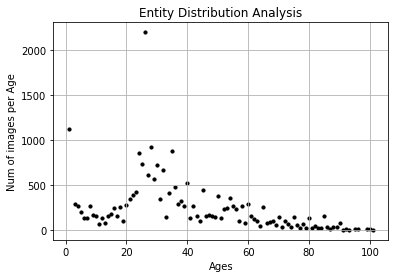

label		Age		Count
0 		 1 		 1123
1 		 3 		 289
2 		 4 		 273
3 		 5 		 196
4 		 6 		 131
5 		 7 		 139
6 		 8 		 263
7 		 9 		 166
8 		 10 		 156
9 		 11 		 65
10 		 12 		 130
11 		 13 		 81
12 		 14 		 157
13 		 15 		 177
14 		 16 		 247
15 		 17 		 158
16 		 18 		 262
17 		 19 		 98
18 		 20 		 284
19 		 21 		 346
20 		 22 		 395
21 		 23 		 426
22 		 24 		 859
23 		 25 		 734
24 		 26 		 2197
25 		 27 		 615
26 		 28 		 918
27 		 29 		 570
28 		 30 		 724
29 		 31 		 350
30 		 32 		 664
31 		 33 		 143
32 		 34 		 409
33 		 35 		 880
34 		 36 		 483
35 		 37 		 293
36 		 38 		 325
37 		 39 		 266
38 		 40 		 526
39 		 41 		 132
40 		 42 		 266
41 		 43 		 157
42 		 44 		 100
43 		 45 		 440
44 		 46 		 153
45 		 47 		 170
46 		 48 		 153
47 		 49 		 148
48 		 50 		 381
49 		 51 		 138
50 		 52 		 232
51 		 53 		 241
52 		 54 		 353
53 		 55 		 268
54 		 56 		 236
55 		 57 		 97
56 		 58 		 271
57 		 59 		 82
58 		 60 		 293
59 		 61 		 161
60 		 62 		 125
61 		 63 		 103
62 		 64 		

In [214]:
dataset_analysis(train_dataset)

# Dataset Loader

In [215]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

In [216]:
len(train_loader)

182

# Model resnet18

# Initialise Model & Optimizer 

In [217]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = models.resnet18(pretrained=True)

# model.fc.in_features is 512
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

params_to_update = model.parameters()
print("Params to learn:")
for name,param in model.named_parameters(): print("\t",name)

model.to(DEVICE)
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
if learning_rate_scheduler:
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [218]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

`torch.max()` `returns` highest elements along the dimension and indexes of highest values, here we are only interested to the indexes of highest elements

In [219]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [220]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

# Training

PyTorch Normally add the previously calculated gradient with the current calculated gradient and then updates the weight. But here we don't want it. That's why we made the previously calculted gradient zero while calculating a new one with `optimizer.zero_grad()`

In [221]:
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
  train_total_num_correct_preds = train_num_examples = 0.0
 
  model.train()
  train_mae=0.0
  for batch_idx, (features, targets) in enumerate(tqdm(train_loader)):
    targets, features =  targets.to(DEVICE), features.to(DEVICE)

    # FORWARD AND BACK PROP
    logits = model(features)
    cost = F.cross_entropy(logits, targets)
    probas = F.softmax(logits, dim=1)
    _, predicted_labels = torch.max(probas, dim=1)
    optimizer.zero_grad()
    cost.backward()

    # UPDATE MODEL PARAMETERS
    optimizer.step()
    # UPDATE LEARNING RATE
    if learning_rate_scheduler:
      scheduler.step()
    
    train_total_num_correct_preds += calculate_correct_preds(logits, targets)
    train_num_examples += targets.size(0) 
    train_mae += torch.sum(torch.abs(predicted_labels - targets))
      
  train_mae = train_mae/train_num_examples
  # LOGGING
  print(f'Correct Train Preds: {train_total_num_correct_preds}')
  training_acc = compute_acc(train_total_num_correct_preds, train_num_examples)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  str1 = f'Epoch: {epoch+1}/{EPOCHS} \n'
  str2 = f'--------------------------------------------------------------------\n'
  str3 = f'Training MAE: {format(train_mae, ".3f")}\n'
  str4 = f'Training_Cost: {format(cost, ".3f")}\n'
  str5 = f'Training_Acc: {training_acc}%\n'
  str6 = f'Time elapsed: {time_elapsed}mins\n'

  str = str1+str2+str3+str4+str5+str6
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')
  
  mode_name = f'Epoch_{epoch+1}_model.pt'
  torch.save(model.state_dict(), os.path.join(PATH, mode_name)) # saving the model
  with open(LOGFILE, 'a') as f: f.write(f'---Model Saved---\n')
  print(f'---Model Saved---\n')
    
with open(LOGFILE, 'a') as f: f.write('\n\n############-------Training Completed-------############\n\n')
print("TRAINING COMPLETED")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 3710.0
Epoch: 1/25 
--------------------------------------------------------------------
Training MAE: 7.895
Training_Cost: 3.059
Training_Acc: 15.987%
Time elapsed: 2.030mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 4383.0
Epoch: 2/25 
--------------------------------------------------------------------
Training MAE: 5.896
Training_Cost: 2.951
Training_Acc: 18.887%
Time elapsed: 4.091mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 4703.0
Epoch: 3/25 
--------------------------------------------------------------------
Training MAE: 5.438
Training_Cost: 3.043
Training_Acc: 20.265%
Time elapsed: 6.166mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 4950.0
Epoch: 4/25 
--------------------------------------------------------------------
Training MAE: 5.069
Training_Cost: 2.728
Training_Acc: 21.330%
Time elapsed: 8.194mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 5352.0
Epoch: 5/25 
--------------------------------------------------------------------
Training MAE: 4.749
Training_Cost: 2.613
Training_Acc: 23.062%
Time elapsed: 10.235mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 5797.0
Epoch: 6/25 
--------------------------------------------------------------------
Training MAE: 4.466
Training_Cost: 2.757
Training_Acc: 24.980%
Time elapsed: 12.301mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 6407.0
Epoch: 7/25 
--------------------------------------------------------------------
Training MAE: 4.202
Training_Cost: 2.465
Training_Acc: 27.608%
Time elapsed: 14.469mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 7167.0
Epoch: 8/25 
--------------------------------------------------------------------
Training MAE: 3.896
Training_Cost: 2.611
Training_Acc: 30.883%
Time elapsed: 16.504mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 8262.0
Epoch: 9/25 
--------------------------------------------------------------------
Training MAE: 3.547
Training_Cost: 2.432
Training_Acc: 35.601%
Time elapsed: 18.538mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 9656.0
Epoch: 10/25 
--------------------------------------------------------------------
Training MAE: 3.116
Training_Cost: 1.926
Training_Acc: 41.608%
Time elapsed: 20.581mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 11623.0
Epoch: 11/25 
--------------------------------------------------------------------
Training MAE: 2.673
Training_Cost: 1.838
Training_Acc: 50.084%
Time elapsed: 22.616mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 13673.0
Epoch: 12/25 
--------------------------------------------------------------------
Training MAE: 2.187
Training_Cost: 1.456
Training_Acc: 58.918%
Time elapsed: 24.664mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 15899.0
Epoch: 13/25 
--------------------------------------------------------------------
Training MAE: 1.688
Training_Cost: 1.284
Training_Acc: 68.509%
Time elapsed: 26.698mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 17696.0
Epoch: 14/25 
--------------------------------------------------------------------
Training MAE: 1.312
Training_Cost: 1.238
Training_Acc: 76.253%
Time elapsed: 28.740mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 19123.0
Epoch: 15/25 
--------------------------------------------------------------------
Training MAE: 0.961
Training_Cost: 0.645
Training_Acc: 82.402%
Time elapsed: 30.785mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 20320.0
Epoch: 16/25 
--------------------------------------------------------------------
Training MAE: 0.707
Training_Cost: 0.886
Training_Acc: 87.560%
Time elapsed: 32.816mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 20817.0
Epoch: 17/25 
--------------------------------------------------------------------
Training MAE: 0.604
Training_Cost: 0.516
Training_Acc: 89.701%
Time elapsed: 34.853mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 21238.0
Epoch: 18/25 
--------------------------------------------------------------------
Training MAE: 0.480
Training_Cost: 0.494
Training_Acc: 91.515%
Time elapsed: 36.888mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 21518.0
Epoch: 19/25 
--------------------------------------------------------------------
Training MAE: 0.435
Training_Cost: 0.479
Training_Acc: 92.722%
Time elapsed: 38.923mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 21791.0
Epoch: 20/25 
--------------------------------------------------------------------
Training MAE: 0.370
Training_Cost: 0.351
Training_Acc: 93.898%
Time elapsed: 40.954mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 21955.0
Epoch: 21/25 
--------------------------------------------------------------------
Training MAE: 0.331
Training_Cost: 0.325
Training_Acc: 94.605%
Time elapsed: 42.994mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 21912.0
Epoch: 22/25 
--------------------------------------------------------------------
Training MAE: 0.339
Training_Cost: 0.478
Training_Acc: 94.420%
Time elapsed: 45.023mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 21902.0
Epoch: 23/25 
--------------------------------------------------------------------
Training MAE: 0.357
Training_Cost: 0.375
Training_Acc: 94.377%
Time elapsed: 47.064mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 21783.0
Epoch: 24/25 
--------------------------------------------------------------------
Training MAE: 0.392
Training_Cost: 0.277
Training_Acc: 93.864%
Time elapsed: 49.104mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 21874.0
Epoch: 25/25 
--------------------------------------------------------------------
Training MAE: 0.360
Training_Cost: 0.233
Training_Acc: 94.256%
Time elapsed: 51.143mins

---Model Saved---

TRAINING COMPLETED


# Evaluation

In [222]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets) in enumerate(data_loader):
          
    targets, features = targets.to(device), features.to(device)
    logits = model(features)
    probas = F.softmax(logits, dim=1)

    _, predicted_labels = torch.max(probas, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

In [223]:
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

  train_mae, train_mse, train_acc = compute_mae_and_mse(model, train_loader, device=DEVICE)
  str1 = f'Training MAE: {train_mae}\n'
  str2 = f'Training RMSE: {train_mse}\n'
  str3 = f'Training Acc: {train_acc}%\n'
  str = str1+str2+str3

  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')

str = f'Total Elapsed Time: {format(((time.time() - start_time)/60), ".3f")} mins \n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

total_num_correct_preds: 21376
Training MAE: 0.471
Training RMSE: 2.331
Training Acc: 92.110%

Total Elapsed Time: 52.521 mins 



# Saving the Model

PyTorch: What's the difference between state_dict and parameters()? [link](https://stackoverflow.com/questions/54746829/pytorch-whats-the-difference-between-state-dict-and-parameters)

In [224]:
# model = model.to(torch.device('cpu'))
# torch.save(model.state_dict(), os.path.join(PATH, 'model.pt'))

# RESNET34

In [225]:
!nvidia-smi

Tue Aug 31 02:58:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    43W / 250W |  13621MiB / 16280MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [226]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)

import copy
import datetime
import pytz

In [227]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [228]:
TRAIN_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/UTKFace_1-101_class-97-label-0-96-final.csv'
IMAGE_PATH_TRAIN = '/content/drive/MyDrive/CSE465/datasets/UTKFace/UTKFace-images'

RANDOM_SEED = 42
MODEL_NAME = "Full-UTK-CE_ResNet34-Pretrained-Finetuned_100%_EPOCHS-25-withoutLRS"
PATH = '/content/drive/MyDrive/CSE465/Models_and_Logs/' + MODEL_NAME

GRAYSCALE = False
NUM_CLASSES = 97
BATCH_SIZE = 128 #64
EPOCHS = 25
learning_rate = 0.0005
NUM_WORKERS = 0
learning_rate_scheduler = False

In [229]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [230]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'training.log')

In [231]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Model Name: {MODEL_NAME}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'Learning Rate: {learning_rate}')
header.append(f'Epochs: {EPOCHS}')
if learning_rate_scheduler:
  header.append(f'Learning Rate Schedule: {learning_rate_scheduler}')

In [232]:
for entry in header:
  print(entry)




Last Run: 2021-08-31 08:58:08.883429+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Model Name: Full-UTK-CE_ResNet34-Pretrained-Finetuned_100%_EPOCHS-25-withoutLRS
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/Full-UTK-CE_ResNet34-Pretrained-Finetuned_100%_EPOCHS-25-withoutLRS
-------------------HyperParameters---------------
No. of Classes: 97
Batch size: 128
Grayscale: False
Learning Rate: 0.0005
Epochs: 25


In [233]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

# Dataset

In [234]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""
    def __init__(self, csv_path, img_dir, transform=None, items=None):

        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')
        
        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        # img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]

In [235]:
custom_transform_train = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.RandomCrop((224, 224)),
                                       transforms.ToTensor(),
                                       ])

In [236]:
train_dataset = UTKFaceDataset(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH_TRAIN,
                               transform=custom_transform_train,
                               items=None
                              )

# Dataset Entity Distribution Analysis

In [237]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

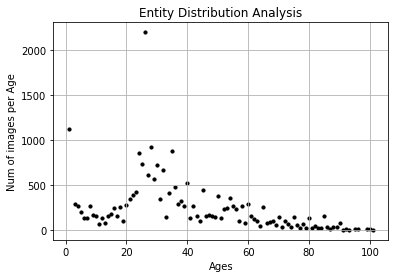

label		Age		Count
0 		 1 		 1123
1 		 3 		 289
2 		 4 		 273
3 		 5 		 196
4 		 6 		 131
5 		 7 		 139
6 		 8 		 263
7 		 9 		 166
8 		 10 		 156
9 		 11 		 65
10 		 12 		 130
11 		 13 		 81
12 		 14 		 157
13 		 15 		 177
14 		 16 		 247
15 		 17 		 158
16 		 18 		 262
17 		 19 		 98
18 		 20 		 284
19 		 21 		 346
20 		 22 		 395
21 		 23 		 426
22 		 24 		 859
23 		 25 		 734
24 		 26 		 2197
25 		 27 		 615
26 		 28 		 918
27 		 29 		 570
28 		 30 		 724
29 		 31 		 350
30 		 32 		 664
31 		 33 		 143
32 		 34 		 409
33 		 35 		 880
34 		 36 		 483
35 		 37 		 293
36 		 38 		 325
37 		 39 		 266
38 		 40 		 526
39 		 41 		 132
40 		 42 		 266
41 		 43 		 157
42 		 44 		 100
43 		 45 		 440
44 		 46 		 153
45 		 47 		 170
46 		 48 		 153
47 		 49 		 148
48 		 50 		 381
49 		 51 		 138
50 		 52 		 232
51 		 53 		 241
52 		 54 		 353
53 		 55 		 268
54 		 56 		 236
55 		 57 		 97
56 		 58 		 271
57 		 59 		 82
58 		 60 		 293
59 		 61 		 161
60 		 62 		 125
61 		 63 		 103
62 		 64 		

In [238]:
dataset_analysis(train_dataset)

# Dataset Loader

In [239]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

In [240]:
len(train_loader)

182

# Model resnet34

# Initialise Model & Optimizer 

In [241]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = models.resnet34(pretrained=True)

# model.fc.in_features is 512
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

params_to_update = model.parameters()
print("Params to learn:")
for name,param in model.named_parameters(): print("\t",name)

model.to(DEVICE)
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
if learning_rate_scheduler:
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer2.2.conv1.weight
	 layer2.2.bn1.weight
	 layer2.2.bn1.bias
	 layer2.2.conv2.weight
	 layer2.2.bn2.weight
	 layer2.2.bn2.bias
	 layer2.3.conv1.weight
	 layer2.3.bn1.weight
	 layer2.3.bn1.

In [242]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

`torch.max()` `returns` highest elements along the dimension and indexes of highest values, here we are only interested to the indexes of highest elements

In [243]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [244]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

# Training

PyTorch Normally add the previously calculated gradient with the current calculated gradient and then updates the weight. But here we don't want it. That's why we made the previously calculted gradient zero while calculating a new one with `optimizer.zero_grad()`

In [245]:
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
  train_total_num_correct_preds = train_num_examples = 0.0
 
  model.train()
  train_mae=0.0
  for batch_idx, (features, targets) in enumerate(tqdm(train_loader)):
    targets, features =  targets.to(DEVICE), features.to(DEVICE)

    # FORWARD AND BACK PROP
    logits = model(features)
    cost = F.cross_entropy(logits, targets)
    probas = F.softmax(logits, dim=1)
    _, predicted_labels = torch.max(probas, dim=1)
    optimizer.zero_grad()
    cost.backward()

    # UPDATE MODEL PARAMETERS
    optimizer.step()
    # UPDATE LEARNING RATE
    if learning_rate_scheduler:
      scheduler.step()
    
    train_total_num_correct_preds += calculate_correct_preds(logits, targets)
    train_num_examples += targets.size(0) 
    train_mae += torch.sum(torch.abs(predicted_labels - targets))
      
  train_mae = train_mae/train_num_examples
  # LOGGING
  print(f'Correct Train Preds: {train_total_num_correct_preds}')
  training_acc = compute_acc(train_total_num_correct_preds, train_num_examples)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  str1 = f'Epoch: {epoch+1}/{EPOCHS} \n'
  str2 = f'--------------------------------------------------------------------\n'
  str3 = f'Training MAE: {format(train_mae, ".3f")}\n'
  str4 = f'Training_Cost: {format(cost, ".3f")}\n'
  str5 = f'Training_Acc: {training_acc}%\n'
  str6 = f'Time elapsed: {time_elapsed}mins\n'

  str = str1+str2+str3+str4+str5+str6
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')
  
  mode_name = f'Epoch_{epoch+1}_model.pt'
  torch.save(model.state_dict(), os.path.join(PATH, mode_name)) # saving the model
  with open(LOGFILE, 'a') as f: f.write(f'---Model Saved---\n')
  print(f'---Model Saved---\n')
    
with open(LOGFILE, 'a') as f: f.write('\n\n############-------Training Completed-------############\n\n')
print("TRAINING COMPLETED")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 3696.0
Epoch: 1/25 
--------------------------------------------------------------------
Training MAE: 7.849
Training_Cost: 2.926
Training_Acc: 15.926%
Time elapsed: 2.440mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 4233.0
Epoch: 2/25 
--------------------------------------------------------------------
Training MAE: 5.851
Training_Cost: 3.147
Training_Acc: 18.240%
Time elapsed: 4.889mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 4516.0
Epoch: 3/25 
--------------------------------------------------------------------
Training MAE: 5.360
Training_Cost: 2.778
Training_Acc: 19.460%
Time elapsed: 7.334mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 4781.0
Epoch: 4/25 
--------------------------------------------------------------------
Training MAE: 5.066
Training_Cost: 3.005
Training_Acc: 20.602%
Time elapsed: 9.781mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 5048.0
Epoch: 5/25 
--------------------------------------------------------------------
Training MAE: 4.771
Training_Cost: 2.878
Training_Acc: 21.752%
Time elapsed: 12.216mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 5219.0
Epoch: 6/25 
--------------------------------------------------------------------
Training MAE: 4.526
Training_Cost: 2.408
Training_Acc: 22.489%
Time elapsed: 14.669mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 5654.0
Epoch: 7/25 
--------------------------------------------------------------------
Training MAE: 4.267
Training_Cost: 2.934
Training_Acc: 24.363%
Time elapsed: 17.110mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 6019.0
Epoch: 8/25 
--------------------------------------------------------------------
Training MAE: 4.024
Training_Cost: 2.403
Training_Acc: 25.936%
Time elapsed: 19.548mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 6488.0
Epoch: 9/25 
--------------------------------------------------------------------
Training MAE: 3.751
Training_Cost: 2.764
Training_Acc: 27.957%
Time elapsed: 21.981mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 7126.0
Epoch: 10/25 
--------------------------------------------------------------------
Training MAE: 3.504
Training_Cost: 2.757
Training_Acc: 30.706%
Time elapsed: 24.420mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 7781.0
Epoch: 11/25 
--------------------------------------------------------------------
Training MAE: 3.276
Training_Cost: 2.321
Training_Acc: 33.529%
Time elapsed: 26.862mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 8570.0
Epoch: 12/25 
--------------------------------------------------------------------
Training MAE: 3.007
Training_Cost: 2.211
Training_Acc: 36.929%
Time elapsed: 29.303mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 9794.0
Epoch: 13/25 
--------------------------------------------------------------------
Training MAE: 2.762
Training_Cost: 1.846
Training_Acc: 42.203%
Time elapsed: 31.745mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 11021.0
Epoch: 14/25 
--------------------------------------------------------------------
Training MAE: 2.503
Training_Cost: 1.895
Training_Acc: 47.490%
Time elapsed: 34.188mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 12476.0
Epoch: 15/25 
--------------------------------------------------------------------
Training MAE: 2.258
Training_Cost: 1.933
Training_Acc: 53.760%
Time elapsed: 36.625mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 14151.0
Epoch: 16/25 
--------------------------------------------------------------------
Training MAE: 1.897
Training_Cost: 1.302
Training_Acc: 60.977%
Time elapsed: 39.070mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 15657.0
Epoch: 17/25 
--------------------------------------------------------------------
Training MAE: 1.596
Training_Cost: 1.167
Training_Acc: 67.467%
Time elapsed: 41.505mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 17258.0
Epoch: 18/25 
--------------------------------------------------------------------
Training MAE: 1.300
Training_Cost: 1.032
Training_Acc: 74.365%
Time elapsed: 43.948mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 18205.0
Epoch: 19/25 
--------------------------------------------------------------------
Training MAE: 1.083
Training_Cost: 0.746
Training_Acc: 78.446%
Time elapsed: 46.395mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 19261.0
Epoch: 20/25 
--------------------------------------------------------------------
Training MAE: 0.872
Training_Cost: 0.713
Training_Acc: 82.997%
Time elapsed: 48.826mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 19956.0
Epoch: 21/25 
--------------------------------------------------------------------
Training MAE: 0.733
Training_Cost: 0.576
Training_Acc: 85.991%
Time elapsed: 51.277mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 20454.0
Epoch: 22/25 
--------------------------------------------------------------------
Training MAE: 0.644
Training_Cost: 0.542
Training_Acc: 88.137%
Time elapsed: 53.722mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 20706.0
Epoch: 23/25 
--------------------------------------------------------------------
Training MAE: 0.590
Training_Cost: 0.598
Training_Acc: 89.223%
Time elapsed: 56.170mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 20989.0
Epoch: 24/25 
--------------------------------------------------------------------
Training MAE: 0.531
Training_Cost: 0.347
Training_Acc: 90.443%
Time elapsed: 58.614mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 21381.0
Epoch: 25/25 
--------------------------------------------------------------------
Training MAE: 0.448
Training_Cost: 0.453
Training_Acc: 92.132%
Time elapsed: 61.080mins

---Model Saved---

TRAINING COMPLETED


# Evaluation

In [246]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets) in enumerate(data_loader):
          
    targets, features = targets.to(device), features.to(device)
    logits = model(features)
    probas = F.softmax(logits, dim=1)

    _, predicted_labels = torch.max(probas, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

In [247]:
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

  train_mae, train_mse, train_acc = compute_mae_and_mse(model, train_loader, device=DEVICE)
  str1 = f'Training MAE: {train_mae}\n'
  str2 = f'Training RMSE: {train_mse}\n'
  str3 = f'Training Acc: {train_acc}%\n'
  str = str1+str2+str3

  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')

str = f'Total Elapsed Time: {format(((time.time() - start_time)/60), ".3f")} mins \n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

total_num_correct_preds: 20953
Training MAE: 0.568
Training RMSE: 2.499
Training Acc: 90.287%

Total Elapsed Time: 62.439 mins 



# Saving the Model

PyTorch: What's the difference between state_dict and parameters()? [link](https://stackoverflow.com/questions/54746829/pytorch-whats-the-difference-between-state-dict-and-parameters)

In [248]:
# model = model.to(torch.device('cpu'))
# torch.save(model.state_dict(), os.path.join(PATH, 'model.pt'))

# RESNET50

In [249]:
!nvidia-smi

Tue Aug 31 04:00:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    46W / 250W |  13621MiB / 16280MiB |     28%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [250]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)

import copy
import datetime
import pytz

In [251]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [252]:
TRAIN_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/UTKFace_1-101_class-97-label-0-96-final.csv'
IMAGE_PATH_TRAIN = '/content/drive/MyDrive/CSE465/datasets/UTKFace/UTKFace-images'

RANDOM_SEED = 42
MODEL_NAME = "Full-UTK-CE_ResNet50-Pretrained-Finetuned_100%_EPOCHS-25-withoutLRS"
PATH = '/content/drive/MyDrive/CSE465/Models_and_Logs/' + MODEL_NAME

GRAYSCALE = False
NUM_CLASSES = 97
BATCH_SIZE = 128 #64
EPOCHS = 25
learning_rate = 0.0005
NUM_WORKERS = 0
learning_rate_scheduler = False

In [253]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [254]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'training.log')

In [255]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Model Name: {MODEL_NAME}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'Learning Rate: {learning_rate}')
header.append(f'Epochs: {EPOCHS}')
if learning_rate_scheduler:
  header.append(f'Learning Rate Schedule: {learning_rate_scheduler}')

In [256]:
for entry in header:
  print(entry)




Last Run: 2021-08-31 10:00:36.428595+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Model Name: Full-UTK-CE_ResNet50-Pretrained-Finetuned_100%_EPOCHS-25-withoutLRS
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/Full-UTK-CE_ResNet50-Pretrained-Finetuned_100%_EPOCHS-25-withoutLRS
-------------------HyperParameters---------------
No. of Classes: 97
Batch size: 128
Grayscale: False
Learning Rate: 0.0005
Epochs: 25


In [257]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

# Dataset

In [258]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""
    def __init__(self, csv_path, img_dir, transform=None, items=None):

        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')
        
        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        # img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]

In [259]:
custom_transform_train = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.RandomCrop((224, 224)),
                                       transforms.ToTensor(),
                                       ])

In [260]:
train_dataset = UTKFaceDataset(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH_TRAIN,
                               transform=custom_transform_train,
                               items=None
                              )

# Dataset Entity Distribution Analysis

In [261]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

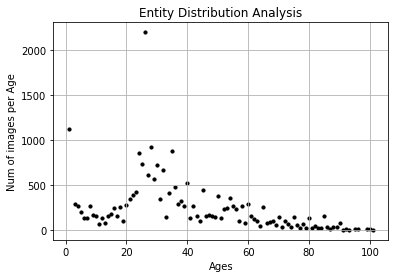

label		Age		Count
0 		 1 		 1123
1 		 3 		 289
2 		 4 		 273
3 		 5 		 196
4 		 6 		 131
5 		 7 		 139
6 		 8 		 263
7 		 9 		 166
8 		 10 		 156
9 		 11 		 65
10 		 12 		 130
11 		 13 		 81
12 		 14 		 157
13 		 15 		 177
14 		 16 		 247
15 		 17 		 158
16 		 18 		 262
17 		 19 		 98
18 		 20 		 284
19 		 21 		 346
20 		 22 		 395
21 		 23 		 426
22 		 24 		 859
23 		 25 		 734
24 		 26 		 2197
25 		 27 		 615
26 		 28 		 918
27 		 29 		 570
28 		 30 		 724
29 		 31 		 350
30 		 32 		 664
31 		 33 		 143
32 		 34 		 409
33 		 35 		 880
34 		 36 		 483
35 		 37 		 293
36 		 38 		 325
37 		 39 		 266
38 		 40 		 526
39 		 41 		 132
40 		 42 		 266
41 		 43 		 157
42 		 44 		 100
43 		 45 		 440
44 		 46 		 153
45 		 47 		 170
46 		 48 		 153
47 		 49 		 148
48 		 50 		 381
49 		 51 		 138
50 		 52 		 232
51 		 53 		 241
52 		 54 		 353
53 		 55 		 268
54 		 56 		 236
55 		 57 		 97
56 		 58 		 271
57 		 59 		 82
58 		 60 		 293
59 		 61 		 161
60 		 62 		 125
61 		 63 		 103
62 		 64 		

In [262]:
dataset_analysis(train_dataset)

# Dataset Loader

In [263]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

In [264]:
len(train_loader)

182

# Model resnet50

# Initialise Model & Optimizer 

In [265]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = models.resnet50(pretrained=True)

# model.fc.in_features is 512
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

params_to_update = model.parameters()
print("Params to learn:")
for name,param in model.named_parameters(): print("\t",name)

model.to(DEVICE)
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
if learning_rate_scheduler:
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

In [266]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

`torch.max()` `returns` highest elements along the dimension and indexes of highest values, here we are only interested to the indexes of highest elements

In [267]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [268]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

# Training

PyTorch Normally add the previously calculated gradient with the current calculated gradient and then updates the weight. But here we don't want it. That's why we made the previously calculted gradient zero while calculating a new one with `optimizer.zero_grad()`

In [269]:
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
  train_total_num_correct_preds = train_num_examples = 0.0
 
  model.train()
  train_mae=0.0
  for batch_idx, (features, targets) in enumerate(tqdm(train_loader)):
    targets, features =  targets.to(DEVICE), features.to(DEVICE)

    # FORWARD AND BACK PROP
    logits = model(features)
    cost = F.cross_entropy(logits, targets)
    probas = F.softmax(logits, dim=1)
    _, predicted_labels = torch.max(probas, dim=1)
    optimizer.zero_grad()
    cost.backward()

    # UPDATE MODEL PARAMETERS
    optimizer.step()
    # UPDATE LEARNING RATE
    if learning_rate_scheduler:
      scheduler.step()
    
    train_total_num_correct_preds += calculate_correct_preds(logits, targets)
    train_num_examples += targets.size(0) 
    train_mae += torch.sum(torch.abs(predicted_labels - targets))
      
  train_mae = train_mae/train_num_examples
  # LOGGING
  print(f'Correct Train Preds: {train_total_num_correct_preds}')
  training_acc = compute_acc(train_total_num_correct_preds, train_num_examples)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  str1 = f'Epoch: {epoch+1}/{EPOCHS} \n'
  str2 = f'--------------------------------------------------------------------\n'
  str3 = f'Training MAE: {format(train_mae, ".3f")}\n'
  str4 = f'Training_Cost: {format(cost, ".3f")}\n'
  str5 = f'Training_Acc: {training_acc}%\n'
  str6 = f'Time elapsed: {time_elapsed}mins\n'

  str = str1+str2+str3+str4+str5+str6
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')
  
  mode_name = f'Epoch_{epoch+1}_model.pt'
  torch.save(model.state_dict(), os.path.join(PATH, mode_name)) # saving the model
  with open(LOGFILE, 'a') as f: f.write(f'---Model Saved---\n')
  print(f'---Model Saved---\n')
    
with open(LOGFILE, 'a') as f: f.write('\n\n############-------Training Completed-------############\n\n')
print("TRAINING COMPLETED")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 3528.0
Epoch: 1/25 
--------------------------------------------------------------------
Training MAE: 8.052
Training_Cost: 3.296
Training_Acc: 15.202%
Time elapsed: 3.374mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 4093.0
Epoch: 2/25 
--------------------------------------------------------------------
Training MAE: 6.080
Training_Cost: 3.525
Training_Acc: 17.637%
Time elapsed: 7.144mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 4264.0
Epoch: 3/25 
--------------------------------------------------------------------
Training MAE: 5.696
Training_Cost: 2.891
Training_Acc: 18.374%
Time elapsed: 10.924mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 4553.0
Epoch: 4/25 
--------------------------------------------------------------------
Training MAE: 5.258
Training_Cost: 3.287
Training_Acc: 19.619%
Time elapsed: 14.703mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 4629.0
Epoch: 5/25 
--------------------------------------------------------------------
Training MAE: 5.109
Training_Cost: 2.824
Training_Acc: 19.947%
Time elapsed: 18.486mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 4804.0
Epoch: 6/25 
--------------------------------------------------------------------
Training MAE: 4.802
Training_Cost: 3.143
Training_Acc: 20.701%
Time elapsed: 22.256mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 5045.0
Epoch: 7/25 
--------------------------------------------------------------------
Training MAE: 4.633
Training_Cost: 2.855
Training_Acc: 21.739%
Time elapsed: 26.025mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 5291.0
Epoch: 8/25 
--------------------------------------------------------------------
Training MAE: 4.424
Training_Cost: 2.884
Training_Acc: 22.799%
Time elapsed: 29.792mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 5392.0
Epoch: 9/25 
--------------------------------------------------------------------
Training MAE: 4.280
Training_Cost: 2.674
Training_Acc: 23.234%
Time elapsed: 33.559mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 5601.0
Epoch: 10/25 
--------------------------------------------------------------------
Training MAE: 4.087
Training_Cost: 2.991
Training_Acc: 24.135%
Time elapsed: 37.331mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 5818.0
Epoch: 11/25 
--------------------------------------------------------------------
Training MAE: 3.987
Training_Cost: 2.561
Training_Acc: 25.070%
Time elapsed: 41.101mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 6099.0
Epoch: 12/25 
--------------------------------------------------------------------
Training MAE: 3.806
Training_Cost: 2.713
Training_Acc: 26.281%
Time elapsed: 44.630mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 6398.0
Epoch: 13/25 
--------------------------------------------------------------------
Training MAE: 3.601
Training_Cost: 2.542
Training_Acc: 27.569%
Time elapsed: 48.046mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 6736.0
Epoch: 14/25 
--------------------------------------------------------------------
Training MAE: 3.449
Training_Cost: 2.715
Training_Acc: 29.026%
Time elapsed: 51.468mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 7183.0
Epoch: 15/25 
--------------------------------------------------------------------
Training MAE: 3.311
Training_Cost: 2.567
Training_Acc: 30.952%
Time elapsed: 54.891mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 7479.0
Epoch: 16/25 
--------------------------------------------------------------------
Training MAE: 3.177
Training_Cost: 2.189
Training_Acc: 32.227%
Time elapsed: 58.307mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 8018.0
Epoch: 17/25 
--------------------------------------------------------------------
Training MAE: 2.998
Training_Cost: 2.032
Training_Acc: 34.550%
Time elapsed: 61.729mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 8692.0
Epoch: 18/25 
--------------------------------------------------------------------
Training MAE: 2.785
Training_Cost: 3.032
Training_Acc: 37.454%
Time elapsed: 65.151mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 9323.0
Epoch: 19/25 
--------------------------------------------------------------------
Training MAE: 2.654
Training_Cost: 1.718
Training_Acc: 40.173%
Time elapsed: 68.578mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 10046.0
Epoch: 20/25 
--------------------------------------------------------------------
Training MAE: 2.520
Training_Cost: 2.114
Training_Acc: 43.289%
Time elapsed: 72.004mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 10818.0
Epoch: 21/25 
--------------------------------------------------------------------
Training MAE: 2.387
Training_Cost: 2.000
Training_Acc: 46.615%
Time elapsed: 75.433mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 11739.0
Epoch: 22/25 
--------------------------------------------------------------------
Training MAE: 2.204
Training_Cost: 2.081
Training_Acc: 50.584%
Time elapsed: 78.858mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 12586.0
Epoch: 23/25 
--------------------------------------------------------------------
Training MAE: 2.002
Training_Cost: 1.455
Training_Acc: 54.234%
Time elapsed: 82.278mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 13600.0
Epoch: 24/25 
--------------------------------------------------------------------
Training MAE: 1.826
Training_Cost: 1.611
Training_Acc: 58.603%
Time elapsed: 85.698mins

---Model Saved---



  0%|          | 0/182 [00:00<?, ?it/s]

Correct Train Preds: 14691.0
Epoch: 25/25 
--------------------------------------------------------------------
Training MAE: 1.623
Training_Cost: 1.519
Training_Acc: 63.304%
Time elapsed: 89.122mins

---Model Saved---

TRAINING COMPLETED


# Evaluation

In [270]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets) in enumerate(data_loader):
          
    targets, features = targets.to(device), features.to(device)
    logits = model(features)
    probas = F.softmax(logits, dim=1)

    _, predicted_labels = torch.max(probas, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

In [271]:
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

  train_mae, train_mse, train_acc = compute_mae_and_mse(model, train_loader, device=DEVICE)
  str1 = f'Training MAE: {train_mae}\n'
  str2 = f'Training RMSE: {train_mse}\n'
  str3 = f'Training Acc: {train_acc}%\n'
  str = str1+str2+str3

  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')

str = f'Total Elapsed Time: {format(((time.time() - start_time)/60), ".3f")} mins \n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

total_num_correct_preds: 14209
Training MAE: 1.855
Training RMSE: 4.139
Training Acc: 61.227%

Total Elapsed Time: 90.463 mins 



# Saving the Model

PyTorch: What's the difference between state_dict and parameters()? [link](https://stackoverflow.com/questions/54746829/pytorch-whats-the-difference-between-state-dict-and-parameters)

In [272]:
# model = model.to(torch.device('cpu'))
# torch.save(model.state_dict(), os.path.join(PATH, 'model.pt'))